# Patent Match Challenge

## Dimitrije Zdrale, Clement Marie, Petko Petkov

This notebook is structured to handle patent similarity and re-ranking experiments using various transformer-based models.

### Required libraries

In [1]:
import os
import json
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder, models, util
from tqdm import tqdm
from pathlib import Path
import time
import types
import re
import pandas as pd
import json
import re
import string
import time
import os
import scipy.sparse
import hashlib, os, pickle, time, warnings, inspect, functools
from pathlib import Path
import numpy as np
import scipy.sparse as sp
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
import math
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, models, util as st_util
from sentence_transformers.evaluation import InformationRetrievalEvaluator
import torch
import logging
from sklearn.model_selection import train_test_split
from sentence_transformers.cross_encoder.losses import BinaryCrossEntropyLoss
from sentence_transformers.cross_encoder.evaluation import CrossEncoderRerankingEvaluator
from sentence_transformers.cross_encoder import CrossEncoderTrainer, CrossEncoderTrainingArguments
from datasets import Dataset

print("Downloading NLTK data (if necessary)...")
nltk_packages = ['wordnet', 'stopwords', 'punkt']
for package in nltk_packages:
    try:
        if package == 'punkt':
            nltk.data.find(f'tokenizers/{package}')
        else:
             nltk.data.find(f'corpora/{package}')
    except:
        try:
           print(f"Downloading NLTK package '{package}'...")
           nltk.download(package, quiet=True)
           print(f"NLTK package '{package}' downloaded.")
        except Exception as e:
            print(f"Error downloading NLTK package '{package}': {e}")
print("NLTK check complete.")

/home/petko/projects/patent-match-challenge/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NLTK package 'wordnet' downloaded.
NLTK check complete.


# Task 1 - pre-ranking

### Preprocess the data

This preprocessing function performs several steps to clean and normalize text data:

- Converts text to lowercase.
- Removes punctuation, digits, and isolated single letters.
- Normalizes whitespace.
- Tokenizes text using NLTK.
- Removes stopwords, using either standard NLTK stopwords or an extended set including domain-specific terms.
- Applies lemmatization by default, with optional stemming if specified (`use_stemming=True`).
- Filters out short tokens (less than 3 characters).

This setup is designed to prepare technical or patent-like text for downstream NLP tasks by reducing noise and focusing on meaningful terms.

In [2]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
custom_stopwords = set([
    'claim', 'claims', 'claimed', 'method', 'system', 'device', 'apparatus', 'assembly', 'unit',
    'comprising', 'comprises', 'thereof', 'wherein', 'said', 'thereby', 'herein', 'accordance',
    'invention', 'present', 'related', 'relates', 'figure', 'fig', 'example', 'examples',
    'embodiment', 'embodiments', 'accordance', 'therein', 'associated', 'provided', 'configured',
    'includes', 'including', 'based', 'least', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'first', 'second', 'third', 'fourth', 'fifth', 'etc', 'eg', 'ie',
    'may', 'further', 'also', 'within', 'upon', 'used', 'using', 'use', 'capable', 'adapted',
    'generally', 'typically', 'respectively', 'particularly', 'preferably', 'various', 'such',
    'described', 'disclosed', 'illustrated', 'shown',
    'portion', 'member', 'element', 'surface', 'axis', 'position', 'direction', 'side', 'end', 'top', 'bottom',
    'lower', 'upper', 'inner', 'outer', 'rear', 'front', 'lateral',
    'set', 'provide', 'generate', 'control', 'controlling', 'operation', 'value', 'signal', 'process', 'data',
    'group', 'range', 'level', 'time', 'number', 'result', 'type', 'form', 'part', 'manner', 'step'
])
all_stopwords = stop_words.union(custom_stopwords)


def preprocess_text(text, use_stemming=False, use_custom_stopwords=True):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)

    current_stopwords = all_stopwords if use_custom_stopwords else stop_words

    if use_stemming:
        processed_tokens = [stemmer.stem(word) for word in tokens if word not in current_stopwords and len(word) > 2]
    else:
        processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in current_stopwords and len(word) > 2]

    return ' '.join(processed_tokens)

### Helper functions

We define a `create_corpus` helper function so we can extract and preprocess the data. It extracts and optionally preprocesses textual content from a structured corpus:
- Supports multiple `text_type` options: `'title'`, `'abstract'`, `'claim1'`, `'claims'`, `'description'`, `'fulltext'`, or combinations like `'title_abstract'`.
- Skips documents with missing identifiers or required text sections.
- Optionally applies text preprocessing (e.g., lemmatization/stemming, stopword removal) unless `config['method'] == 'dense'`.
- Tracks and reports the number of documents skipped.
- Returns a list of dictionaries with `'id'` and `'text'` keys for each valid document.

This function is designed to flexibly extract and clean specific sections of patent documents for downstream analysis or modeling.

In [2]:
def load_json_data(file_path):
    try:
        with open(file_path, "r", encoding='utf-8') as file:
            contents = json.load(file)
        return contents
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {file_path}: {e}")
        return None

DATASETS_DIR = Path("./datasets")

def load_all():
    content = DATASETS_DIR / "Content_JSONs"
    citing_train = load_json_data(content/"Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
    citing_test  = load_json_data(content/"Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")
    nonciting    = load_json_data(content/"Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
    mapping      = pd.DataFrame(load_json_data(DATASETS_DIR/"Citation_JSONs/Citation_Train.json"))
    return citing_train, citing_test, nonciting, mapping

def add_query_prefix(text):
    if not isinstance(text, str):
            text = str(text)
    return f"query: {text}"

def add_passage_prefix(text):
    if not isinstance(text, str):
            text = str(text)
    return f"passage: {text}"

TEXT_PARTS = {
    "title": ["title"],
    "abstract": ["pa01"],
    "claim1": ["c-en-0001"],
    "title_abstract_claims": ["title", "pa01"] + [f"c-en-{i:04d}" for i in range(1, 101)]
}

def build_corpus(records: list[dict], text_type: str) -> tuple[list[str], list[str]]:
    ids, texts = [], []
    parts = TEXT_PARTS[text_type]
    for rec in records:
        doc_id = rec.get('Application_Number','') + rec.get('Application_Category','')
        if not doc_id: continue
        content = rec.get('Content', {})
        segments = [content[k] for k in parts if content.get(k)]
        if segments:
            texts.append(' '.join(segments))
            ids.append(doc_id)
    return ids, texts

def create_corpus(corpus, text_type, preprocess=False, config={}):
    if not corpus:
        print(f"Warning: Attempting to create corpus from empty or None input for '{text_type}'.")
        return []

    app_ids = []
    texts = []
    cnt = 0

    print(f"Creating corpus for text_type: '{text_type}'...")

    required_parts = []
    if 'title' in text_type: required_parts.append('title')
    if 'abstract' in text_type: required_parts.append('pa01')
    if 'claim1' in text_type: required_parts.append('c-en-0001')

    for doc in tqdm(corpus, desc=f"Processing {text_type}", leave=False):
        doc_id = doc.get('Application_Number', '') + doc.get('Application_Category', '')
        if not doc_id:
            cnt+=1
            continue
        content = doc.get('Content', {})
        if not content:
             cnt += 1
             continue

        doc_text_parts = []
        missing_part = False

        part_map = {
            'title': ['title'],
            'abstract': ['pa01'],
            'claim1': ['c-en-0001'],
            'claims': [k for k in content if k.startswith('c-en-')],
            'description': [k for k in content if k.startswith('p')],
            'fulltext': list(content.keys())
        }

        keys_to_extract = set()
        if text_type == 'title_abstract': keys_to_extract.update(part_map['title'] + part_map['abstract'])
        elif text_type == 'title_abstract_claim1': keys_to_extract.update(part_map['title'] + part_map['abstract'] + part_map['claim1'])
        elif text_type == 'title_abstract_claims': keys_to_extract.update(part_map['title'] + part_map['abstract'] + part_map['claims'])
        elif text_type in part_map: keys_to_extract.update(part_map[text_type])
        else: print(f"Warning: Unknown text_type '{text_type}' in create_corpus.")

        extracted_texts = [content.get(key) for key in keys_to_extract if content.get(key)]
        doc_text_parts = list(dict.fromkeys(filter(None, extracted_texts)))

        if text_type in ['title', 'abstract', 'claim1', 'claims', 'description']:
             if not doc_text_parts:
                 missing_part = True

        if not doc_text_parts or missing_part:
            cnt += 1
        else:
            final_text = ' '.join(doc_text_parts)

            if preprocess and config.get('method') != 'dense':
                use_stemming_flag = config.get('use_stemming', False)
                use_custom_stopwords_flag = config.get('use_custom_stopwords', True)
                final_text = preprocess_text(final_text, use_stemming=use_stemming_flag, use_custom_stopwords=use_custom_stopwords_flag)

            if not final_text or not final_text.strip():
                 cnt += 1
            else:
                texts.append(final_text)
                app_ids.append(doc_id)

    if cnt > 0:
         print(f"Number of documents skipped (missing ID/Content or required text part for '{text_type}' or empty after preprocess): {cnt}")
         final_count = len(app_ids)
         print(f"Original corpus size: {len(corpus)}. Final corpus size: {final_count}")
         if final_count == 0:
              print(f"Warning: Resulting corpus for '{text_type}' is empty!")

    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]
    return corpus_data

### TF-IDF

We generate TF-IDF feature matrices for two sets of text data:
- Concatenates `citing_texts` and `nonciting_texts` to fit the provided or default `TfidfVectorizer`.
- Separately transforms the citing and non-citing texts into sparse TF-IDF matrices.
- Prints progress updates and the resulting vocabulary size.
- Returns three objects:
  - `tfidf_matrix_citing`: TF-IDF matrix for citing documents.
  - `tfidf_matrix_nonciting`: TF-IDF matrix for non-citing documents.
  - `vectorizer`: The fitted TF-IDF vectorizer, which can be reused for other transformations.


In [4]:
def create_tfidf_matrix(
    citing_texts,
    nonciting_texts,
    vectorizer: TfidfVectorizer = TfidfVectorizer(),
):
    vectorizer.fit(nonciting_texts + citing_texts)
    tfidf_matrix_citing = vectorizer.transform(citing_texts)
    tfidf_matrix_nonciting = vectorizer.transform(nonciting_texts)

    return tfidf_matrix_citing, tfidf_matrix_nonciting, vectorizer

### BM25

We implement the BM25 ranking function for computing similarity between queries and documents:
- **Initialization**: Accepts a matrix of vectorized documents (typically non-citing), along with BM25 parameters `k1` and `b`.
- **`.fit()`**: 
  - Converts input to a CSR matrix if needed.
  - Computes average document length and inverse document frequency (IDF) for each term.
  - Ensures numerical stability with smoothing and clamping.
- **`.predict()`**:
  - Accepts a matrix of query vectors (typically citing documents).
  - Calculates BM25 similarity scores between each query and all fitted documents.
  - Uses the BM25 scoring formula in a vectorized fashion for efficiency.

We generate BM25 similarity scores between citing and non-citing texts:
- Fits a `CountVectorizer` on the combined corpus.
- Transforms citing and non-citing texts into count matrices.
- Initializes and fits the `BM25Score` model using the non-citing text matrix.
- Computes and returns the BM25 similarity scores from citing to non-citing documents.
- Also returns the fitted `vectorizer` and `bm25` model for reuse or inspection.

In [5]:
class BM25Score:
    def __init__(self, vectorized_docs, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.vectorized_docs = vectorized_docs

    def fit(self, vectorized_queries=None, query_ids=None, args=None):
        if not isinstance(self.vectorized_docs, scipy.sparse.csr_matrix):
            try:
                self.vectorized_docs = scipy.sparse.csr_matrix(self.vectorized_docs)
            except Exception as e:
                print(f"Error converting BM25 input to CSR: {e}")
                raise

        self.n_d = self.vectorized_docs.sum(axis=1).A
        self.avgdl = np.mean(self.n_d)
        if self.avgdl == 0:
            print("Warning: Average document length is zero. Setting to 1.")
            self.avgdl = 1.0

        self.n_docs = self.vectorized_docs.shape[0]
        self.nq = np.array(self.vectorized_docs.getnnz(axis=0)).reshape(1,-1)
        epsilon = 1e-9
        self.idf = np.log(((self.n_docs - self.nq + 0.5) / (self.nq + 0.5 + epsilon)) + 1.0)
        self.idf = np.maximum(self.idf, 0)
        return self

    def predict(self, vectorized_queries):
        if not isinstance(vectorized_queries, scipy.sparse.csr_matrix):
            try:
                vectorized_queries = scipy.sparse.csr_matrix(vectorized_queries)
            except Exception as e:
                print(f"Error converting BM25 query input to CSR: {e}")
                raise

        if vectorized_queries.shape[1] != self.vectorized_docs.shape[1]:
             raise ValueError(f"Query vector shape {vectorized_queries.shape} incompatible with document vector shape {self.vectorized_docs.shape}")

        idf = self.idf
        term_freq_docs = self.vectorized_docs
        term_freq_queries = vectorized_queries

        doc_len_norm_factor = self.k1 * (1 - self.b + self.b * (self.n_d / self.avgdl))
        k1_plus_1 = self.k1 + 1
        denominator = term_freq_docs.copy().astype(np.float32)

        denominator_dense = term_freq_docs.toarray() + doc_len_norm_factor
        denominator_dense[denominator_dense == 0] = 1e-9

        score_part_docs = term_freq_docs.multiply(k1_plus_1)
        score_part_docs_dense = score_part_docs.toarray() / denominator_dense

        weighted_scores = score_part_docs_dense * idf

        query_term_presence = (term_freq_queries > 0).astype(np.float32)
        final_scores = query_term_presence @ weighted_scores.T

        return final_scores


def create_bm25_matrix(
    citing_texts,
    nonciting_texts,
    vectorizer: CountVectorizer = CountVectorizer(),
    bm25_params: dict = None,
):
    if bm25_params is None:
        bm25_params = {"k1": 1.5, "b": 0.75}

    vectorizer.fit(nonciting_texts + citing_texts)
    count_matrix_citing = vectorizer.transform(citing_texts)
    count_matrix_nonciting = vectorizer.transform(nonciting_texts)

    bm25 = BM25Score(count_matrix_nonciting, **bm25_params).fit()
    bm25_scores = bm25.predict(count_matrix_citing)

    return bm25_scores, vectorizer, bm25

# FINETUNE E5

This script configures and fine-tunes a SentenceTransformer (“intfloat/e5-large-v2”) on patent data by:  
1. Loading and prefix-labeling “query” (citing) and “passage” (cited/non-cited) texts, then splitting them into train and validation sets.  
2. Constructing positive pairs for training and sampling hard negatives for evaluation, wrapped as `InputExample`s and fed into a `DataLoader`.  
3. Initializing the model with a 512-token max length, using `MultipleNegativesRankingLoss`, and evaluating retrieval performance via `InformationRetrievalEvaluator`.  
4. Running `model.fit()` for 3 epochs with warm-up, checkpointing, mixed-precision, and saving the best fine-tuned model.

In [6]:
BASE_MODEL_NAME = "intfloat/e5-large-v2"
FINETUNED_MODEL_PATH = Path("./fine_tuned_patent_model")
FINETUNED_MODEL_PATH.mkdir(exist_ok=True)

TEXT_TYPE_FINETUNE = "title_abstract_claims"

NUM_EPOCHS = 3
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 16
WARMUP_STEPS = 100
LEARNING_RATE = 2e-5
EVALUATION_STEPS = 500
MAX_SEQ_LENGTH = 512
USE_AMP = True

VALIDATION_SPLIT_FRACTION = 0.05
SEED = 2025

try:
    if 'CITING_TRAIN' not in locals() or 'NONCITING' not in locals() or 'MAP_DF' not in locals():
            print("Reloading data...")
            CITING_TRAIN, _, NONCITING, MAP_DF = load_all()
    if 'build_corpus' not in locals():
            raise NameError("build_corpus function not defined.")
except NameError as e:
    print(f"Error: Required data or function not found: {e}")


print("Preparing data for fine-tuning with prefixes...")

def add_query_prefix(text):
    if not isinstance(text, str):
            text = str(text)
    return f"query: {text}"

def add_passage_prefix(text):
    if not isinstance(text, str):
            text = str(text)
    return f"passage: {text}"

print("Building text lookup maps...")
citing_text_map = {}
citing_ids_ft, citing_texts_ft = build_corpus(CITING_TRAIN, TEXT_TYPE_FINETUNE)
for doc_id, text in zip(citing_ids_ft, citing_texts_ft):
    citing_text_map[doc_id] = text

nonciting_text_map = {}
nonciting_ids_ft, nonciting_texts_ft = build_corpus(NONCITING, TEXT_TYPE_FINETUNE)
for doc_id, text in zip(nonciting_ids_ft, nonciting_texts_ft):
    nonciting_text_map[doc_id] = text
print(f"Built maps: {len(citing_text_map)} citing, {len(nonciting_text_map)} non-citing docs.")

train_examples = []
dev_queries = {}
dev_corpus = {}
dev_relevant_docs = {}

all_citing_ids = list(citing_text_map.keys())
random.seed(SEED)
random.shuffle(all_citing_ids)
split_idx = int(len(all_citing_ids) * (1 - VALIDATION_SPLIT_FRACTION))
train_citing_ids = set(all_citing_ids[:split_idx])
dev_citing_ids = set(all_citing_ids[split_idx:])

print(f"Split: {len(train_citing_ids)} train queries, {len(dev_citing_ids)} dev queries.")

processed_pairs = 0
missing_texts = 0
dev_positives_count = 0

for _, row in tqdm(MAP_DF.iterrows(), total=len(MAP_DF), desc="Processing citation pairs"):
    citing_id = row[0]
    cited_id = row[2]

    query_text_orig = citing_text_map.get(citing_id)
    positive_text_orig = citing_text_map.get(cited_id)
    if not positive_text_orig:
        positive_text_orig = nonciting_text_map.get(cited_id)

    if query_text_orig and positive_text_orig:
        prefixed_query = add_query_prefix(query_text_orig)
        prefixed_positive = add_passage_prefix(positive_text_orig)

        if citing_id in train_citing_ids:
            train_examples.append(InputExample(texts=[prefixed_query, prefixed_positive]))
            processed_pairs += 1
        elif citing_id in dev_citing_ids:
            if citing_id not in dev_queries:
                dev_queries[citing_id] = prefixed_query
            if cited_id not in dev_corpus:
                dev_corpus[cited_id] = prefixed_positive
            dev_relevant_docs.setdefault(citing_id, set()).add(cited_id)
            dev_positives_count += 1
    else:
        missing_texts += 1


print(f"Created {len(train_examples)} training examples.")
print(f"Prepared {len(dev_queries)} dev queries with {dev_positives_count} positive relations.")
if missing_texts > 0:
    print(f"Warning: Skipped {missing_texts} pairs due to missing text for citing or cited patents.")

num_dev_negatives_needed = len(dev_corpus) * 5
dev_negatives_added = 0
nonciting_ids_list = list(nonciting_text_map.keys())
random.shuffle(nonciting_ids_list)

for neg_id in nonciting_ids_list:
    if dev_negatives_added >= num_dev_negatives_needed:
        break
    if neg_id not in dev_corpus:
        neg_text = nonciting_text_map.get(neg_id)
        if neg_text:
                dev_corpus[neg_id] = add_passage_prefix(neg_text)
                dev_negatives_added += 1

print(f"Added {dev_negatives_added} negative documents (passages) to the dev corpus.")
print(f"Total dev corpus size: {len(dev_corpus)}")

if not train_examples:
    print("Error: No training examples were created. Check data loading and matching.")
if not dev_queries or not dev_corpus or not dev_relevant_docs:
    print("Error: Validation set data is incomplete. Check validation split and data processing.")
for qid in dev_queries:
    if not dev_relevant_docs.get(qid):
            print(f"Warning: Dev query {qid} has no relevant documents listed in dev_relevant_docs.")

print(f"Loading base model: {BASE_MODEL_NAME}")
model = SentenceTransformer(BASE_MODEL_NAME)

model.max_seq_length = MAX_SEQ_LENGTH
print(f"Model max sequence length set to: {model.max_seq_length}")

loss = losses.MultipleNegativesRankingLoss(model=model)
print("Using MultipleNegativesRankingLoss.")

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
print(f"Train dataloader created with batch size {TRAIN_BATCH_SIZE}.")

evaluator = InformationRetrievalEvaluator(
    queries=dev_queries,
    corpus=dev_corpus,
    relevant_docs=dev_relevant_docs,
    batch_size=EVAL_BATCH_SIZE,
    main_score_function='cosine',
    score_functions={'cos_sim': st_util.cos_sim},
    name='patent_dev',
    show_progress_bar=True,
    write_csv=True,
)
print("InformationRetrievalEvaluator configured.")

print("\n--- Starting Fine-Tuning Training ---")

steps_per_epoch = math.ceil(len(train_dataloader))
print(f"Steps per epoch: {steps_per_epoch}")
if EVALUATION_STEPS > steps_per_epoch:
    print(f"Warning: EVALUATION_STEPS ({EVALUATION_STEPS}) > steps per epoch ({steps_per_epoch}). Evaluation will happen less than once per epoch.")

model.fit(
    train_objectives=[(train_dataloader, loss)],
    evaluator=evaluator,
    epochs=NUM_EPOCHS,
    evaluation_steps=EVALUATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    optimizer_params={'lr': LEARNING_RATE},
    output_path=str(FINETUNED_MODEL_PATH),
    save_best_model=True,
    checkpoint_path=str(FINETUNED_MODEL_PATH / "checkpoints"),
    checkpoint_save_steps=EVALUATION_STEPS * 2,
    checkpoint_save_total_limit=3,
    use_amp=USE_AMP,
    show_progress_bar=True
)

print(f"\n--- Fine-tuning finished ---")
print(f"Best model saved to: {FINETUNED_MODEL_PATH}")

Reloading data...
Preparing data for fine-tuning with prefixes...
Building text lookup maps...
Built maps: 6831 citing, 16834 non-citing docs.
Split: 6489 train queries, 342 dev queries.


Processing citation pairs: 100%|██████████| 8594/8594 [00:00<00:00, 43345.02it/s]


Created 8142 training examples.
Prepared 342 dev queries with 452 positive relations.
Added 2235 negative documents (passages) to the dev corpus.
Total dev corpus size: 2682
Loading base model: intfloat/e5-large-v2
Model max sequence length set to: 512
Using MultipleNegativesRankingLoss.
Train dataloader created with batch size 8.
InformationRetrievalEvaluator configured.

--- Starting Fine-Tuning Training ---
Steps per epoch: 1018


Step,Training Loss,Validation Loss,Patent Dev Cos Sim Accuracy@1,Patent Dev Cos Sim Accuracy@3,Patent Dev Cos Sim Accuracy@5,Patent Dev Cos Sim Accuracy@10,Patent Dev Cos Sim Precision@1,Patent Dev Cos Sim Precision@3,Patent Dev Cos Sim Precision@5,Patent Dev Cos Sim Precision@10,Patent Dev Cos Sim Recall@1,Patent Dev Cos Sim Recall@3,Patent Dev Cos Sim Recall@5,Patent Dev Cos Sim Recall@10,Patent Dev Cos Sim Ndcg@10,Patent Dev Cos Sim Mrr@10,Patent Dev Cos Sim Map@100
500,0.127600,No log,0.529240,0.716374,0.777778,0.871345,0.529240,0.282651,0.190643,0.111111,0.444639,0.660770,0.728704,0.843665,0.674649,0.642145,0.615417
1000,0.092400,No log,0.552632,0.766082,0.839181,0.897661,0.552632,0.301170,0.207602,0.114620,0.465107,0.701657,0.794347,0.870565,0.705589,0.673787,0.646201
1018,0.092400,No log,0.576023,0.783626,0.850877,0.903509,0.576023,0.305068,0.209942,0.116667,0.482164,0.715546,0.806287,0.883967,0.723403,0.693447,0.663382
1500,0.034600,No log,0.576023,0.783626,0.850877,0.923977,0.576023,0.303119,0.208187,0.118129,0.485331,0.718470,0.804337,0.899561,0.727648,0.694540,0.663536
2000,0.036300,No log,0.546784,0.754386,0.845029,0.900585,0.546784,0.293372,0.207018,0.115205,0.455361,0.692544,0.797027,0.874220,0.700813,0.666869,0.638448
2036,0.036300,No log,0.570175,0.760234,0.836257,0.891813,0.570175,0.299220,0.205848,0.114620,0.473392,0.699464,0.792008,0.866910,0.707521,0.678743,0.650170
2500,0.024500,No log,0.587719,0.780702,0.859649,0.923977,0.587719,0.306043,0.213450,0.118129,0.491910,0.720322,0.819834,0.899951,0.734561,0.702085,0.673576
3000,0.023000,No log,0.576023,0.789474,0.874269,0.923977,0.576023,0.307992,0.216374,0.119006,0.479727,0.726267,0.835916,0.904922,0.733874,0.697994,0.670244
3054,0.023000,No log,0.573099,0.792398,0.871345,0.923977,0.573099,0.308967,0.215205,0.119006,0.478752,0.727729,0.831530,0.904922,0.733443,0.696938,0.669709


Corpus Chunks: 100%|██████████| 1/1 [00:22<00:00, 22.38s/it]



--- Fine-tuning finished ---
Best model saved to: fine_tuned_patent_model


In [7]:
# os.environ["HF_TOKEN"] = "YOUR_TOKEN"

# repo_name = "e5-large-v2-patent"
# repo_id = f"petkopetkov/{repo_name}"

# model_path = f"{FINETUNED_MODEL_PATH}/checkpoints/checkpoint-2898"

# print(f"Loading best model from: {model_path}")
# best_model = SentenceTransformer(str(model_path))

# best_model.save_to_hub(
#     repo_id=repo_id,
# )
# print(f"Model successfully uploaded to: https://huggingface.co/{repo_id}")

### Dense embeddings

We generate dense vector embeddings for input texts using a Sentence Transformers model:
- Loads a specified model (default: `multi-qa-mpnet-base-dot-v1`) on GPU if available.
- Encodes text in batches to produce dense embeddings as NumPy arrays.
- Handles errors related to model loading or inference.
- Returns `None` if Sentence Transformers is not available or if encoding fails.

We compute cosine similarity between two sets of dense embeddings:
- Accepts NumPy arrays or PyTorch tensors for citing and non-citing embeddings.
- Converts PyTorch tensors to NumPy arrays if needed.
- Returns a similarity matrix where each row represents a citing document and each column a non-citing one.
- Returns `None` if embeddings are missing or similarity calculation fails.

In [8]:
def create_dense_embeddings(
    texts,
    model_name: str = "multi-qa-mpnet-base-dot-v1",
    batch_size: int = 64,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SentenceTransformer(model_name, device=device)
    
    emb = model.encode(
        texts,
        convert_to_numpy=True,
        show_progress_bar=True,
        batch_size=batch_size,
        normalize_embeddings=False,
    )

    return emb

def calculate_dense_similarity(citing_embeddings, nonciting_embeddings):
    if citing_embeddings is None or nonciting_embeddings is None:
        print("Cannot calculate dense similarity due to missing embeddings.")
        return None
    print("Calculating Dense Cosine Similarities...")
    if isinstance(citing_embeddings, torch.Tensor):
        citing_embeddings = citing_embeddings.cpu().numpy()
    if isinstance(nonciting_embeddings, torch.Tensor):
        nonciting_embeddings = nonciting_embeddings.cpu().numpy()
    try:
        similarity_scores = cosine_similarity(citing_embeddings, nonciting_embeddings)
        return similarity_scores
    except Exception as e:
        print(f"Error calculating cosine similarity: {e}")
        return None

### Metrics

### Evaluation Metric Functions

#### `get_true_and_predicted(citing_to_cited_dict, recommendations_dict)`
Prepares ground truth and predicted labels for evaluation:
- Matches citing document IDs from the recommendations with the mapping dictionary.
- Returns:
  - `true_labels`: list of cited document ID lists.
  - `predicted_labels`: list of predicted document ID lists.
  - `not_in_citation_mapping`: count of citing documents not found in the ground truth.

#### `mean_recall_at_k(true_labels, predicted_labels, k=10)`
Calculates the mean recall at cutoff rank `k`:
- For each query, computes the fraction of relevant documents retrieved in the top-`k` predictions.
- Returns the average recall across all queries.

#### `mean_average_precision(true_labels, predicted_labels, k=10)`
Computes Mean Average Precision (MAP) at rank `k`:
- For each query, calculates precision at each relevant hit in the top-`k` predictions.
- Averages these per-query precision values over all relevant documents.
- Returns the mean of average precision scores across all queries.

#### `mean_ranking(true_labels, predicted_labels)`
Computes the average rank position of relevant documents:
- For each query, determines the rank position of each relevant document in the predictions.
- Returns the mean of these ranks across all queries.
- Penalizes missed documents with the maximum possible rank.

In [9]:
def get_mapping_dict(mapping_df):
    mapping_dict = {}
    if not isinstance(mapping_df, pd.DataFrame) or mapping_df.shape[1] < 3:
        print("Warning: mapping_df invalid in get_mapping_dict.")
        return mapping_dict
    for _, row in mapping_df.iterrows():
        try:
            key = row.iloc[0]
            value = row.iloc[2]
            if key in mapping_dict:
                mapping_dict[key].append(value)
            else:
                mapping_dict[key] = [value]
        except IndexError:
            print(f"Warning: Index error in mapping_df row: {row}")
            continue
    return mapping_dict

def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0
    if not recommendations_dict: return [], [], 0
    for citing_id in recommendations_dict.keys():
        if citing_id in citing_to_cited_dict:
            true_labels.append(citing_to_cited_dict[citing_id])
            prediction = recommendations_dict[citing_id]
            predicted_labels.append(prediction if isinstance(prediction, list) else [])
        else:
            not_in_citation_mapping += 1
    return true_labels, predicted_labels, not_in_citation_mapping

def mean_recall_at_k(true_labels, predicted_labels, k=10):
    recalls_at_k = []
    if not true_labels or not predicted_labels: return 0.0
    for true, pred in zip(true_labels, predicted_labels):
        if not isinstance(true, (list, set)) or not isinstance(pred, list): continue
        true_set = set(true)
        if not true_set: continue
        actual_k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:actual_k] if item in true_set)
        recall = relevant_count / len(true_set)
        recalls_at_k.append(recall)
    mean_recall = sum(recalls_at_k) / len(recalls_at_k) if recalls_at_k else 0
    return mean_recall

def mean_average_precision(true_labels, predicted_labels, k=10):
    average_precisions = []
    if not true_labels or not predicted_labels: return 0.0
    for true, pred in zip(true_labels, predicted_labels):
        if not isinstance(true, (list, set)) or not isinstance(pred, list): continue
        true_set = set(true)
        if not true_set: continue
        precision_at_k = []
        relevant_count = 0
        actual_k = min(k, len(pred))
        for i, item in enumerate(pred[:actual_k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)
    mean_average_precision_val = sum(average_precisions) / len(average_precisions) if average_precisions else 0
    return mean_average_precision_val

def mean_ranking(true_labels, predicted_labels):
    mean_ranks = []
    if not true_labels or not predicted_labels: return float('inf')
    for true, pred in zip(true_labels, predicted_labels):
        if not isinstance(true, (list, set)) or not isinstance(pred, list): continue
        if not true: continue
        ranks = []
        pred_list = list(pred)
        max_rank = len(pred_list) + 1
        for item in true:
            try:
                rank = pred_list.index(item) + 1
            except ValueError:
                rank = max_rank
            ranks.append(rank)
        mean_rank = sum(ranks) / len(ranks) if ranks else max_rank
        mean_ranks.append(mean_rank)
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks) if mean_ranks else float('inf')
    return mean_of_mean_ranks

### Rankings

We generate top-`k` ranked recommendations for each citing document based on similarity scores:
- Validates input dimensions and handles errors gracefully.
- Converts sparse or non-array score types to NumPy arrays.
- Sorts scores in descending order and retrieves top-`k` non-citing document IDs for each citing document.
- Returns a dictionary: `{citing_id: [top_k_nonciting_ids]}`.

We combine multiple ranking outputs using **Reciprocal Rank Fusion (RRF)**:
- Requires at least two ranking dictionaries with overlapping query IDs.
- Computes a combined score for each document using the formula: `1 / (k + rank)`.
- Sorts documents per query by descending fused score.
- Returns a new dictionary with combined rankings: `{query_id: [ranked_doc_ids]}`.

RRF is useful for aggregating rankings from multiple models or similarity measures, enhancing diversity and robustness of final recommendations.

In [10]:
def top_k_ranks(citing_corpus_data, nonciting_corpus_data, similarity_scores, k=10):
    top_k_results = {}
    if similarity_scores is None or not citing_corpus_data or not nonciting_corpus_data:
        print("Warning: Cannot generate ranks due to missing scores or corpus data.")
        return top_k_results

    num_citing = similarity_scores.shape[0]
    num_nonciting = len(nonciting_corpus_data)

    if num_citing != len(citing_corpus_data):
         print(f"Warning: Citing scores ({num_citing}) != citing corpus ({len(citing_corpus_data)}). Adjusting...")
         num_citing = min(num_citing, len(citing_corpus_data))

    if similarity_scores.shape[1] != num_nonciting:
        print(f"Warning: Similarity score columns ({similarity_scores.shape[1]}) != non-citing docs ({num_nonciting}). Cannot rank.")
        return {}

    actual_k = min(k, num_nonciting)
    print(f"Generating top {actual_k} ranks...")
    for i in tqdm(range(num_citing), desc="Ranking", leave=False):
        try:
            citing_id = citing_corpus_data[i]['id']
            patent_scores = similarity_scores[i]
            if isinstance(patent_scores, (np.matrix, scipy.sparse.spmatrix)):
                patent_scores = patent_scores.toarray().flatten()
            elif not isinstance(patent_scores, np.ndarray):
                 patent_scores = np.array(patent_scores)

            if patent_scores.ndim != 1 or len(patent_scores) != num_nonciting:
                 print(f"Warning: Skipping citing ID {citing_id} due to score shape/length mismatch.")
                 continue

            top_indices = np.argsort(-patent_scores)[:actual_k] # Negate scores
            top_nonciting_ids = [nonciting_corpus_data[j]['id'] for j in top_indices if j < num_nonciting]
            top_k_results[citing_id] = top_nonciting_ids
        except IndexError as e:
            print(f"Warning: Index error processing citing item {i} (ID: {citing_corpus_data[i].get('id', 'N/A')}). Skipping. Error: {e}")
        except Exception as e:
            print(f"Warning: Unexpected error processing citing item {i} (ID: {citing_corpus_data[i].get('id', 'N/A')}): {e}. Skipping.")
    return top_k_results


def combine_rankings_rrf(rank_dict_list, k_rrf=60):
    print(f"Combining {len(rank_dict_list)} rankings using RRF (k={k_rrf})...")
    if not rank_dict_list or len(rank_dict_list) < 2:
        print("Warning: Need at least two ranking lists for RRF.")
        return rank_dict_list[0] if rank_dict_list else {}

    query_ids = set(rank_dict_list[0].keys())
    for r_dict in rank_dict_list[1:]:
        query_ids.intersection_update(r_dict.keys())
    if not query_ids:
        print("Warning: No common query IDs found among ranking lists for RRF.")
        return {}

    combined_scores = {query_id: {} for query_id in query_ids}
    print(f"Processing {len(query_ids)} common queries for RRF.")

    for ranks_dict in tqdm(rank_dict_list, desc="Processing Rank Lists", leave=False):
        for query_id in query_ids:
            ranked_docs = ranks_dict.get(query_id, [])
            for rank, doc_id in enumerate(ranked_docs):
                rank_score = 1.0 / (k_rrf + rank + 1)
                combined_scores[query_id][doc_id] = combined_scores[query_id].get(doc_id, 0) + rank_score

    final_rankings = {}
    for query_id, doc_scores in tqdm(combined_scores.items(), desc="Sorting RRF Results", leave=False):
        sorted_docs = sorted(doc_scores.items(), key=lambda item: (-item[1], item[0]))
        final_rankings[query_id] = [doc_id for doc_id, score in sorted_docs]

    return final_rankings

### Experiment setup

**Process Overview**:
  1. **Corpus Creation**: Extracts and optionally preprocesses texts for citing and non-citing documents.
  2. **Similarity Calculation**:
     - `tfidf`: Uses `TfidfVectorizer` and cosine similarity.
     - `bm25`: Uses `CountVectorizer` and BM25 scoring.
     - `dense`: Uses Sentence Transformers and cosine similarity on embeddings.
  3. **Ranking**: Generates top-k ranked results for each citing document.
  4. **RRF Preparation**: Stores rankings if needed for Reciprocal Rank Fusion (RRF).
  5. **Evaluation**: Computes key metrics:
     - `Recall@10`, `20`, `50`, `100`
     - `MAP@100` (Mean Average Precision)
     - `Mean Rank`
     - Count of measured queries and those missing from the mapping

- **Outputs**:
  - `metrics`: Dictionary of evaluation metrics.
  - `model_details_run`: Includes trained vectorizers/models and non-citing representation data (matrix or embeddings).

- **Error Handling**:
  - Skips experiments if corpora are empty or libraries are missing.
  - Gracefully handles exceptions and prints tracebacks for debugging.

In [11]:
def run_experiment(config, json_citing_train, json_nonciting, mapping_dict, k_eval=100):
    start_time = time.time()
    print(f"\n--- Running Experiment: {config['name']} ---")

    print("Creating corpora...")
    citing_corpus = create_corpus(json_citing_train, config['text_type'], preprocess=config.get('preprocess', False), config=config)
    nonciting_corpus = create_corpus(json_nonciting, config['text_type'], preprocess=config.get('preprocess', False), config=config)

    if not citing_corpus or not nonciting_corpus:
        print("Skipping experiment due to empty corpus.")
        return None, None

    citing_texts = [doc['text'] for doc in citing_corpus]
    nonciting_texts = [doc['text'] for doc in nonciting_corpus]

    similarity_scores = None
    fitted_vectorizer = None
    fitted_bm25_model = None
    nonciting_matrix_tfidf = None
    nonciting_embeddings = None
    model_details_run = {}

    try:
        if config['method'] == 'tfidf':
            vectorizer = TfidfVectorizer(**config.get('vectorizer_params', {}))
            tfidf_citing, tfidf_nonciting, fitted_vectorizer = create_tfidf_matrix(
                citing_texts, nonciting_texts, vectorizer
            )
            print("Calculating Cosine Similarities...")
            similarity_scores = linear_kernel(tfidf_citing, tfidf_nonciting)
            nonciting_matrix_tfidf = tfidf_nonciting

        elif config['method'] == 'bm25':
            vectorizer = CountVectorizer(**config.get('vectorizer_params', {}))
            bm25_scores, fitted_vectorizer, fitted_bm25_model = create_bm25_matrix(
                citing_texts, nonciting_texts, vectorizer, config.get('bm25_params', {})
            )
            similarity_scores = bm25_scores

        elif config['method'] == 'dense':
            model_name = config.get('embedding_model')
            needs_prefix = model_name and ("e5" in model_name.lower())
            
            if needs_prefix:
                print(f"Applying E5 prefixes for model: {model_name}")
                prefixed_citing_texts = [add_query_prefix(text) for text in citing_texts]
                prefixed_nonciting_texts = [add_passage_prefix(text) for text in nonciting_texts]
            else:
                prefixed_citing_texts = citing_texts
                prefixed_nonciting_texts = nonciting_texts

            print("Generating Dense Embeddings...")
            citing_embeddings = create_dense_embeddings(
                prefixed_citing_texts,
                model_name=config.get('embedding_model'),
                batch_size=config.get('embedding_batch_size')
            )
            nonciting_embeddings = create_dense_embeddings(
                prefixed_nonciting_texts,
                model_name=config.get('embedding_model'),
                batch_size=config.get('embedding_batch_size'),
            )
            if citing_embeddings is None or nonciting_embeddings is None:
                 raise ValueError("Dense embedding generation failed.")
            similarity_scores = calculate_dense_similarity(citing_embeddings, nonciting_embeddings)
            model_details_run['nonciting_embeddings'] = nonciting_embeddings # Store needed embeddings

        else:
            print(f"Unknown method: {config['method']}")
            return None, None

        if similarity_scores is None:
            raise ValueError("Failed to compute similarity scores.")

        print(f"Shape of similarity/scores matrix: {similarity_scores.shape}")

        full_rank = top_k_ranks(citing_corpus, nonciting_corpus, similarity_scores, k=len(nonciting_corpus))
        
        best_bm25_config_name_for_rrf = 'T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9)'
        best_dense_config_name_for_rrf = 'Dense (e5‑large‑v2-patent)'
        best_mean_rank_bm25_config_name = 'T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8)'

        if config['name'] == best_bm25_config_name_for_rrf:
            print(f"Storing BM25 (Best MAP/Recall) ranks for RRF from {config['name']}...")
            global best_bm25_ranks_train
            best_bm25_ranks_train = full_rank
        elif config['name'] == best_dense_config_name_for_rrf:
            print(f"Storing Dense ranks for RRF from {config['name']}...")
            global best_dense_ranks_train
            best_dense_ranks_train = full_rank
        elif config['name'] == best_mean_rank_bm25_config_name:
            print(f"Storing BM25 (Best Mean Rank) ranks for RRF from {config['name']}...")
            global best_mean_rank_bm25_ranks_train
            best_mean_rank_bm25_ranks_train = full_rank

        top_k_rank_eval = {qid: ranks[:k_eval] for qid, ranks in full_rank.items()}
        print("Calculating metrics...")
        true_labels, predicted_labels, not_in_mapping = get_true_and_predicted(mapping_dict, top_k_rank_eval)

        if not predicted_labels:
            print("No predictions generated for metric calculation.")
            metrics = {'recall@10': 0,'recall@20': 0,'recall@50': 0,'recall@100': 0, 'map@100': 0, 'mean_rank': float('inf'), 'num_measured': 0, 'not_in_mapping': not_in_mapping}
        else:
            metrics = {
                'recall@10': mean_recall_at_k(true_labels, predicted_labels, k=10),
                'recall@20': mean_recall_at_k(true_labels, predicted_labels, k=20),
                'recall@50': mean_recall_at_k(true_labels, predicted_labels, k=50),
                'recall@100': mean_recall_at_k(true_labels, predicted_labels, k=100),
                'map@100': mean_average_precision(true_labels, predicted_labels, k=100),
                'mean_rank': mean_ranking(true_labels, predicted_labels),
                'num_measured': len(predicted_labels), 'not_in_mapping': not_in_mapping
            }

        print(f"Recall@10: {metrics['recall@10']:.4f}")
        print(f"Recall@100: {metrics['recall@100']:.4f}")
        print(f"MAP@100: {metrics['map@100']:.4f}")
        print(f"Mean Rank: {metrics['mean_rank']:.4f}")

        model_details_run.update({
            'vectorizer': fitted_vectorizer, # None for dense
            'bm25_model': fitted_bm25_model, # None for tfidf/dense
            'nonciting_corpus': nonciting_corpus,
            'nonciting_matrix': nonciting_matrix_tfidf, # None for bm25/dense
            'nonciting_embeddings': model_details_run.get('nonciting_embeddings', None) # Added if dense
        })

    except Exception as e:
        print(f"Error during experiment '{config['name']}': {e}")
        import traceback
        traceback.print_exc()
        return None, None

    end_time = time.time()
    print(f"Experiment '{config['name']}' completed in {end_time - start_time:.2f} seconds.")

    return metrics, model_details_run

### Experiments configuration

**Files Loaded**:
  - `citing_TRAIN.json`: Citing documents (training set)
  - `citing_TEST.json`: Citing documents (test set)
  - `CLEANED_CONTENT_DATASET_cited...json`: Pool of non-citing documents
  - `Citation_Train.json`: Mapping of citing-to-cited pairs
- **Validation**: Ensures all files are loaded; exits if any are missing.
- **Metadata Printed**:
  - Document counts for each loaded dataset
  - Size of generated citing-to-cited mapping dictionary (`mapping_dict`)

#### **Experiment Setup**
- **Configurations Defined**:
  - Specifies multiple experiment configurations using various retrieval methods (`bm25`, `dense`)
  - Each config includes relevant parameters (e.g., preprocessing flags, model/vectorizer details)
- **Best Configs for RRF**:
  - Named configs designated for Reciprocal Rank Fusion (RRF), based on prior performance:
    - `best_bm25_config_name_for_rrf`
    - `best_dense_config_name_for_rrf`
    - `best_mean_rank_bm25_config_name`
- **Dense Model Handling**:
  - Dense configurations are removed if Sentence Transformers library is not available.
- **Results Initialization**:
  - Tracks best performance across configurations using recall@100, MAP@100, and stores top model configuration and details.
- **Global Variables for RRF**:
  - Prepares variables (`best_bm25_ranks_train`, etc.) to store rankings used in later rank fusion steps.

In [12]:
print("\nLoading datasets...")
DATA_DIR = "./datasets"
content_path = os.path.join(DATA_DIR, "Content_JSONs")
citation_path = os.path.join(DATA_DIR, "Citation_JSONs")
path_citing_train = os.path.join(content_path, "Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
path_citing_test = os.path.join(content_path, "Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")
path_nonciting = os.path.join(content_path, "Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
path_citations = os.path.join(citation_path, "Citation_Train.json")

json_citing_train = load_json_data(path_citing_train)
json_citing_test = load_json_data(path_citing_test)
json_nonciting = load_json_data(path_nonciting)
json_citing_to_cited = load_json_data(path_citations)

if not all([json_citing_train, json_citing_test, json_nonciting, json_citing_to_cited]):
    print("\nCritical Error: One or more dataset files failed to load. Please check paths. Exiting.")
    exit()

print("\nDatasets loaded successfully.")
print(f"Citing Train: {len(json_citing_train)}")
print(f"Citing Test: {len(json_citing_test)}")
print(f"Non-Citing Pool: {len(json_nonciting)}")
print(f"Training Citations Raw Pairs: {len(json_citing_to_cited)}")

mapping_dataset_df = pd.DataFrame(json_citing_to_cited)
mapping_dict = get_mapping_dict(mapping_dataset_df)
print(f"Training Citations Dict (Unique Citing Patents): {len(mapping_dict)}")

best_bm25_config_name_for_rrf = 'T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9)'
best_dense_config_name_for_rrf = 'Dense (e5‑large‑v2-patent)'
best_mean_rank_bm25_config_name = 'T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8)'

configs = [
    {'name': 'Title BM25', 'method': 'bm25', 'text_type': 'title', 'preprocess': False, 'vectorizer_params': {'stop_words': 'english', 'max_features': 10000}, 'bm25_params': {'k1': 1.5, 'b': 0.75}},
    {'name': 'Claim1 BM25', 'method': 'bm25', 'text_type': 'claim1', 'preprocess': False, 'vectorizer_params': {'stop_words': 'english', 'max_features': 10000}, 'bm25_params': {'k1': 1.5, 'b': 0.75}},
    {'name': best_bm25_config_name_for_rrf,
     'method': 'bm25', 'text_type': 'title_abstract_claims',
     'preprocess': True, 'use_stemming': False, 'use_custom_stopwords': True,
     'vectorizer_params': {'max_features': 20000, 'ngram_range': (1, 1), 'min_df': 1},
     'bm25_params': {'k1': 2.0, 'b': 0.9}},
    {'name': best_mean_rank_bm25_config_name,
     'method': 'bm25', 'text_type': 'title_abstract_claims',
     'preprocess': True, 'use_stemming': False, 'use_custom_stopwords': True,
     'vectorizer_params': {'max_features': 20000, 'ngram_range': (1, 1), 'min_df': 1},
     'bm25_params': {'k1': 2.5, 'b': 0.8}},
    {'name': best_dense_config_name_for_rrf,
     'method': 'dense', 'text_type': 'title_abstract_claims', 'preprocess': False,
     'embedding_model': 'multi-qa-mpnet-base-dot-v1', 'embedding_batch_size': 128 },
    {'name': 'Dense (PatentSBERTa, T+A+Claims)',
     'method': 'dense', 'text_type': 'title_abstract_claims', 'preprocess': False,
     'embedding_model': 'AI-Growth-Lab/PatentSBERTa', 'embedding_batch_size': 64 },
    {
        'name': 'T+A+Claims BM25 1‑3gram',
        'method': 'bm25',
        'text_type': 'title_abstract_claims',
        'preprocess': True,
        'vectorizer_params': {'max_features': 40000,
                            'ngram_range': (1, 3),
                            'token_pattern': r'(?u)\\b\\w[\\w\\-\\.\\&]+\\b'},
        'bm25_params':   {'k1': 1.4, 'b': 0.55}
    },
    {
        'name': 'Dense (e5‑large‑v2-patent)',
        'method': 'dense',
        'text_type': 'title_abstract_claims',
        'preprocess': False,
        'embedding_model': 'petkopetkov/e5-large-v2-patent',
        'embedding_batch_size': 256
    },
]

results = {}
best_recall_100 = -1.0
best_map_100 = -1.0
best_config_name_recall = None
best_config_name_map = None
best_model_details = {}
best_model_config = None

best_bm25_ranks_train = None
best_dense_ranks_train = None
best_mean_rank_bm25_ranks_train = None


Loading datasets...

Datasets loaded successfully.
Citing Train: 6831
Citing Test: 1000
Non-Citing Pool: 16837
Training Citations Raw Pairs: 8594
Training Citations Dict (Unique Citing Patents): 6831


### Training

#### **Running Configured Experiments**
- Iterates over each configuration in `configs` and runs the corresponding experiment using `run_experiment`.
- Uses `k_eval = 100` for metric evaluation (e.g., Recall@100, MAP@100).

#### **Results Tracking**
- Stores metrics for each experiment under `results[config_name]`.
- Continuously updates and tracks:
  - **Best MAP@100**:
    - Stores name, config, and model details for the best-performing model by MAP.
  - **Best Recall@100**:
    - Similarly tracks the configuration with the highest recall at rank 100.
- If the same config achieves both best MAP and best Recall, it's saved as the best overall model.

#### **Error Handling**
- Prints a message if an experiment fails or returns no metrics, ensuring traceability during batch runs.

In [13]:
print("\n=== Running Experiments on Training Data ===")
k_eval_metrics = 100

if not all([json_citing_train, json_nonciting, mapping_dict]):
     print("Cannot run experiments, datasets not loaded properly.")
else:
    for config in configs:
        metrics, model_details_run = run_experiment(config, json_citing_train, json_nonciting, mapping_dict, k_eval=k_eval_metrics)
        if metrics:
            results[config['name']] = metrics
            current_recall_100 = metrics['recall@100']
            current_map_100 = metrics['map@100']

            if current_map_100 > best_map_100:
                 best_map_100 = current_map_100
                 best_config_name_map = config['name']
                 best_model_details = model_details_run
                 best_model_config = config
                 print(f"*** New best MAP@100 model found: {best_config_name_map} ({best_map_100:.4f}) ***")

            if current_recall_100 > best_recall_100:
                 best_recall_100 = current_recall_100
                 best_config_name_recall = config['name']
                 if config['name'] == best_config_name_map:
                     best_model_details = model_details_run
                     best_model_config = config
                 print(f"*** New best Recall@100 model found: {best_config_name_recall} ({best_recall_100:.4f}) ***")
        else:
            print(f"--- Experiment {config['name']} failed or produced no results. ---")


=== Running Experiments on Training Data ===

--- Running Experiment: Title BM25 ---
Creating corpora...
Creating corpus for text_type: 'title'...


Creating corpus for text_type: 'title'...


Shape of similarity/scores matrix: (6831, 16837)
Generating top 16837 ranks...


Calculating metrics...
Recall@10: 0.2723
Recall@100: 0.4733
MAP@100: 0.1744
Mean Rank: 61.9337
Experiment 'Title BM25' completed in 24.84 seconds.
*** New best MAP@100 model found: Title BM25 (0.1744) ***
*** New best Recall@100 model found: Title BM25 (0.4733) ***

--- Running Experiment: Claim1 BM25 ---
Creating corpora...
Creating corpus for text_type: 'claim1'...


Creating corpus for text_type: 'claim1'...


Number of documents skipped (missing ID/Content or required text part for 'claim1' or empty after preprocess): 3
Original corpus size: 16837. Final corpus size: 16834
Shape of similarity/scores matrix: (6831, 16834)
Generating top 16834 ranks...


Calculating metrics...
Recall@10: 0.4148
Recall@100: 0.6589
MAP@100: 0.2700
Mean Rank: 45.5658
Experiment 'Claim1 BM25' completed in 27.59 seconds.
*** New best MAP@100 model found: Claim1 BM25 (0.2700) ***
*** New best Recall@100 model found: Claim1 BM25 (0.6589) ***

--- Running Experiment: T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9) ---
Creating corpora...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Shape of similarity/scores matrix: (6831, 16837)
Generating top 16837 ranks...


Storing BM25 (Best MAP/Recall) ranks for RRF from T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9)...
Calculating metrics...
Recall@10: 0.5614
Recall@100: 0.8166
MAP@100: 0.3703
Mean Rank: 29.6142
Experiment 'T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9)' completed in 81.49 seconds.
*** New best MAP@100 model found: T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9) (0.3703) ***
*** New best Recall@100 model found: T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9) (0.8166) ***

--- Running Experiment: T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8) ---
Creating corpora...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Shape of similarity/scores matrix: (6831, 16837)
Generating top 16837 ranks...


Storing BM25 (Best Mean Rank) ranks for RRF from T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8)...
Calculating metrics...
Recall@10: 0.5636
Recall@100: 0.8200
MAP@100: 0.3725
Mean Rank: 29.2354
Experiment 'T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8)' completed in 72.89 seconds.
*** New best MAP@100 model found: T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8) (0.3725) ***
*** New best Recall@100 model found: T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8) (0.8200) ***

--- Running Experiment: Dense (e5‑large‑v2-patent) ---
Creating corpora...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Generating Dense Embeddings...


Batches: 100%|██████████| 132/132 [03:18<00:00,  1.50s/it]


Calculating Dense Cosine Similarities...
Shape of similarity/scores matrix: (6831, 16837)
Generating top 16837 ranks...


Storing Dense ranks for RRF from Dense (e5‑large‑v2-patent)...
Calculating metrics...
Recall@10: 0.4989
Recall@100: 0.7856
MAP@100: 0.3220
Mean Rank: 33.8777
Experiment 'Dense (e5‑large‑v2-patent)' completed in 310.75 seconds.

--- Running Experiment: Dense (PatentSBERTa, T+A+Claims) ---
Creating corpora...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Generating Dense Embeddings...


Batches: 100%|██████████| 264/264 [03:30<00:00,  1.25it/s]


Calculating Dense Cosine Similarities...
Shape of similarity/scores matrix: (6831, 16837)
Generating top 16837 ranks...


Calculating metrics...
Recall@10: 0.4982
Recall@100: 0.7848
MAP@100: 0.3209
Mean Rank: 34.0136
Experiment 'Dense (PatentSBERTa, T+A+Claims)' completed in 333.27 seconds.

--- Running Experiment: T+A+Claims BM25 1‑3gram ---
Creating corpora...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Traceback (most recent call last):                                                      
  File "/tmp/ipykernel_5768/1678864667.py", line 35, in run_experiment
    bm25_scores, fitted_vectorizer, fitted_bm25_model = create_bm25_matrix(
                                                        ^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_5768/1486923287.py", line 70, in create_bm25_matrix
    vectorizer.fit(nonciting_texts + citing_texts)
  File "/home/petko/projects/patent-match-challenge/env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1327, in fit
    self.fit_transform(raw_documents)
  File "/home/petko/projects/patent-match-challenge/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/petko/projects/patent-match-challenge/env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocab

Error during experiment 'T+A+Claims BM25 1‑3gram': empty vocabulary; perhaps the documents only contain stop words
--- Experiment T+A+Claims BM25 1‑3gram failed or produced no results. ---

--- Running Experiment: Dense (e5‑large‑v2-patent) ---
Creating corpora...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Applying E5 prefixes for model: petkopetkov/e5-large-v2-patent
Generating Dense Embeddings...


Batches: 100%|██████████| 66/66 [09:16<00:00,  8.43s/it]


Calculating Dense Cosine Similarities...
Shape of similarity/scores matrix: (6831, 16837)
Generating top 16837 ranks...


Storing Dense ranks for RRF from Dense (e5‑large‑v2-patent)...
Calculating metrics...
Recall@10: 0.7029
Recall@100: 0.9515
MAP@100: 0.4574
Mean Rank: 15.1205
Experiment 'Dense (e5‑large‑v2-patent)' completed in 799.03 seconds.
*** New best MAP@100 model found: Dense (e5‑large‑v2-patent) (0.4574) ***
*** New best Recall@100 model found: Dense (e5‑large‑v2-patent) (0.9515) ***


### Evaluate RRF on training data

#### **Overview**
This section evaluates hybrid retrieval methods using **Reciprocal Rank Fusion (RRF)** to combine results from multiple base models (e.g., BM25 and Dense).

#### **Prerequisites**
- RRF is only executed if ranking results are available from:
  - Best MAP@100 BM25 config (`best_bm25_ranks_train`)
  - Best Mean Rank BM25 config (`best_mean_rank_bm25_ranks_train`)
  - Best Dense config (`best_dense_ranks_train`)

Warnings are shown if required rankings are missing.

---

#### **Variant 1: RRF (Best MAP BM25 + Best Dense)**
- Combines rankings from:
  - BM25 model with best MAP@100
  - Dense model with best MAP@100
- Evaluates RRF with varying `k` values: `10`, `60`, and `120`.
- For each fusion, calculates metrics:
  - `Recall@10/20/50/100`
  - `MAP@100`
  - `Mean Rank`
- Tracks and updates the best RRF configuration based on MAP@100.

---

#### **Variant 2: RRF (Best Mean Rank BM25 + Best Dense)**
- Uses a fixed `k=60` to combine:
  - BM25 model with best Mean Rank
  - Dense model with best MAP@100
- Evaluates and tracks the resulting metrics similar to Variant 1.
- Updates the best RRF config if it outperforms others based on MAP@100.

---

#### **RRF Results Storage**
- All evaluated RRF configurations and their metrics are stored in `rrf_results`.
- The best-performing fusion (by MAP@100) is saved in `best_rrf_config_details`.

RRF offers a powerful ensemble approach to blend complementary retrieval strengths from lexical (BM25) and semantic (dense) methods.

In [14]:
print("\n=== Evaluating Hybrid RRF Variants on Training Data ===")
rrf_results = {}
best_rrf_map = -1.0
best_rrf_config_details = {}

rrf_possible_best_map = best_bm25_ranks_train is not None and best_dense_ranks_train is not None
rrf_possible_best_mean_rank = best_mean_rank_bm25_ranks_train is not None and best_dense_ranks_train is not None

if not rrf_possible_best_map: print(f"Warning: Ranks missing for BM25 MAP ('{best_bm25_config_name_for_rrf}') or Dense ('{best_dense_config_name_for_rrf}'). Cannot run primary RRF.")
if not rrf_possible_best_mean_rank: print(f"Warning: Ranks missing for BM25 Mean Rank ('{best_mean_rank_bm25_config_name}') or Dense ('{best_dense_config_name_for_rrf}'). Cannot run alternative RRF.")

if rrf_possible_best_map:
    base_rank_list = [best_bm25_ranks_train, best_dense_ranks_train]
    bm25_map_val = results.get(best_bm25_config_name_for_rrf, {}).get('map@100', 0)
    dense_map_val = results.get(best_dense_config_name_for_rrf, {}).get('map@100', 0)
    base_component_names = f"BM25(MAP={bm25_map_val:.3f}) + Dense(MAP={dense_map_val:.3f})"

    for rrf_k_val in [10, 60, 120]:
        rrf_name = f"RRF (k={rrf_k_val}, {base_component_names})"
        print(f"\nEvaluating: {rrf_name}")
        try:
            rrf_combined_ranks = combine_rankings_rrf(base_rank_list, k_rrf=rrf_k_val)
            true_labels_rrf, predicted_labels_rrf, not_in_mapping_rrf = get_true_and_predicted(mapping_dict, rrf_combined_ranks)
            if not predicted_labels_rrf: raise ValueError("No predictions from RRF combine.")

            metrics = {
                'recall@10': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=10),
                'recall@20': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=20),
                'recall@50': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=50),
                'recall@100': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=100),
                'map@100': mean_average_precision(true_labels_rrf, predicted_labels_rrf, k=100),
                'mean_rank': mean_ranking(true_labels_rrf, predicted_labels_rrf),
                'num_measured': len(predicted_labels_rrf), 'not_in_mapping': not_in_mapping_rrf
            }
            rrf_results[rrf_name] = metrics
            print(f"  RRF Metrics: R@100={metrics['recall@100']:.4f}, MAP@100={metrics['map@100']:.4f}, MeanRank={metrics['mean_rank']:.2f}")

            if metrics['map@100'] > best_rrf_map:
                best_rrf_map = metrics['map@100']
                best_rrf_config_details = {
                    'name': rrf_name, 'k': rrf_k_val,
                    'bm25_config_name': best_bm25_config_name_for_rrf,
                    'dense_config_name': best_dense_config_name_for_rrf,
                    'metrics': metrics}
                print(f"  *** New best RRF configuration found: {rrf_name} (MAP@100: {best_rrf_map:.4f}) ***")
        except Exception as e: print(f"Error evaluating {rrf_name}: {e}")

if rrf_possible_best_mean_rank:
    alt_rank_list = [best_mean_rank_bm25_ranks_train, best_dense_ranks_train]
    bm25_mr_val = results.get(best_mean_rank_bm25_config_name,{}).get('mean_rank', float('inf'))
    dense_map_val = results.get(best_dense_config_name_for_rrf,{}).get('map@100',0)
    alt_component_names = f"BM25(MR={bm25_mr_val:.2f}) + Dense(MAP={dense_map_val:.3f})"
    rrf_k_val = 60
    rrf_name = f"RRF (k={rrf_k_val}, {alt_component_names})"
    print(f"\nEvaluating: {rrf_name}")
    try:
        rrf_combined_ranks = combine_rankings_rrf(alt_rank_list, k_rrf=rrf_k_val)
        true_labels_rrf, predicted_labels_rrf, not_in_mapping_rrf = get_true_and_predicted(mapping_dict, rrf_combined_ranks)
        if not predicted_labels_rrf: raise ValueError("No predictions from RRF combine.")

        metrics = {
            'recall@10': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=10),
            'recall@20': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=20),
            'recall@50': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=50),
            'recall@100': mean_recall_at_k(true_labels_rrf, predicted_labels_rrf, k=100),
            'map@100': mean_average_precision(true_labels_rrf, predicted_labels_rrf, k=100),
            'mean_rank': mean_ranking(true_labels_rrf, predicted_labels_rrf),
            'num_measured': len(predicted_labels_rrf), 'not_in_mapping': not_in_mapping_rrf
        }
        rrf_results[rrf_name] = metrics
        print(f"  RRF Metrics: R@100={metrics['recall@100']:.4f}, MAP@100={metrics['map@100']:.4f}, MeanRank={metrics['mean_rank']:.2f}")

        if metrics['map@100'] > best_rrf_map:
            best_rrf_map = metrics['map@100']
            best_rrf_config_details = {
                'name': rrf_name, 'k': rrf_k_val,
                'bm25_config_name': best_mean_rank_bm25_config_name, # Use the mean rank one
                'dense_config_name': best_dense_config_name_for_rrf,
                'metrics': metrics}
            print(f"  *** New best RRF configuration found: {rrf_name} (MAP@100: {best_rrf_map:.4f}) ***")
    except Exception as e: print(f"Error evaluating {rrf_name}: {e}")


=== Evaluating Hybrid RRF Variants on Training Data ===

Evaluating: RRF (k=10, BM25(MAP=0.370) + Dense(MAP=0.457))
Combining 2 rankings using RRF (k=10)...
Processing 6831 common queries for RRF.


  RRF Metrics: R@100=0.9622, MAP@100=0.4947, MeanRank=20.19
  *** New best RRF configuration found: RRF (k=10, BM25(MAP=0.370) + Dense(MAP=0.457)) (MAP@100: 0.4947) ***

Evaluating: RRF (k=60, BM25(MAP=0.370) + Dense(MAP=0.457))
Combining 2 rankings using RRF (k=60)...
Processing 6831 common queries for RRF.


  RRF Metrics: R@100=0.9616, MAP@100=0.4796, MeanRank=20.39

Evaluating: RRF (k=120, BM25(MAP=0.370) + Dense(MAP=0.457))
Combining 2 rankings using RRF (k=120)...
Processing 6831 common queries for RRF.


  RRF Metrics: R@100=0.9599, MAP@100=0.4751, MeanRank=21.26

Evaluating: RRF (k=60, BM25(MR=29.24) + Dense(MAP=0.457))
Combining 2 rankings using RRF (k=60)...
Processing 6831 common queries for RRF.


  RRF Metrics: R@100=0.9618, MAP@100=0.4806, MeanRank=20.22


### Determine final best prediction method

#### **Objective**
Identify the best-performing prediction approach using **MAP@100** as the primary evaluation metric.

#### **Selection Logic**
- Compares the best RRF configuration's `MAP@100` (`best_rrf_map`) with the best single model's `MAP@100` (`best_map_100`).
- **If RRF outperforms all single models**:
  - Selects RRF as the best method.
  - Stores its config and metrics in `final_prediction_config`.
- **Otherwise**:
  - Selects the best single model configuration.
  - Also stores associated model details (e.g., vectorizer or embeddings).

#### **Fallback Handling**
- If no valid method is determined, logs a warning for further inspection.

#### **Results Update**
- Merges `rrf_results` into the overall `results` dictionary for unified tracking.

This step finalizes which method should be used for making predictions and optionally for downstream testing or deployment.

In [15]:
print("\n--- Determining Best Prediction Method ---")
best_method_for_prediction = None
final_prediction_config = None

if best_rrf_map > best_map_100 and best_rrf_config_details:
    print(f"Best method is RRF: '{best_rrf_config_details['name']}' (MAP@100: {best_rrf_map:.4f})")
    best_method_for_prediction = 'rrf'
    final_prediction_config = best_rrf_config_details
elif best_config_name_map:
    print(f"Best method is Single Model: '{best_config_name_map}' (MAP@100: {best_map_100:.4f})")
    best_method_for_prediction = best_config_name_map
    final_prediction_config = best_model_config
    if final_prediction_config: final_prediction_config['details'] = best_model_details
else:
    print("Warning: Could not determine best method. Check experiment results and logs.")

results.update(rrf_results)


--- Determining Best Prediction Method ---
Best method is RRF: 'RRF (k=10, BM25(MAP=0.370) + Dense(MAP=0.457))' (MAP@100: 0.4947)


### Plot results


=== Experiment Results Summary ===
                                                 recall@10  recall@20  \
RRF (k=10, BM25(MAP=0.370) + Dense(MAP=0.457))    0.747777   0.833072   
RRF (k=60, BM25(MR=29.24) + Dense(MAP=0.457))     0.724299   0.828019   
RRF (k=60, BM25(MAP=0.370) + Dense(MAP=0.457))    0.722952   0.827534   
RRF (k=120, BM25(MAP=0.370) + Dense(MAP=0.457))   0.708703   0.810867   
Dense (e5‑large‑v2-patent)                        0.702894   0.802698   
T+A+Claims BM25 (Pre, ngram=1, k1=2.5, b=0.8)     0.563578   0.649344   
T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9)     0.561397   0.646806   
Dense (PatentSBERTa, T+A+Claims)                  0.498202   0.591290   
Claim1 BM25                                       0.414756   0.483260   
Title BM25                                        0.272266   0.332760   

                                                 recall@50  recall@100  \
RRF (k=10, BM25(MAP=0.370) + Dense(MAP=0.457))    0.918987    0.962238   
RRF (k=60, B

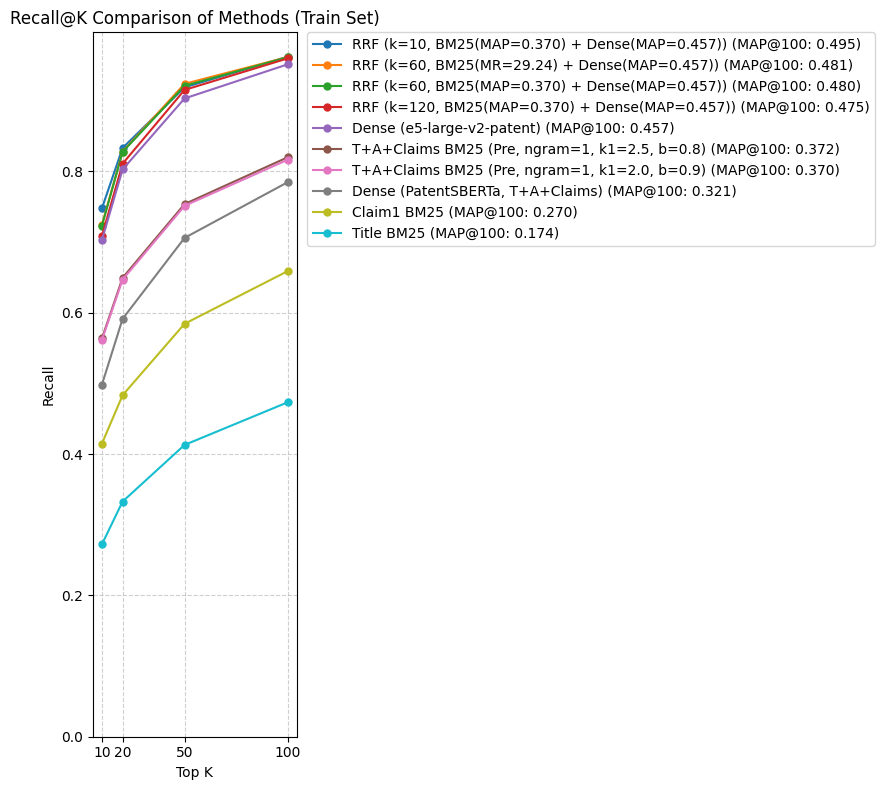

In [16]:
print("\n=== Experiment Results Summary ===")
if results:
    results_df = pd.DataFrame(results).T.sort_values(by='map@100', ascending=False) # Sort by MAP
    pd.set_option('display.max_rows', None)
    print(results_df)
    pd.reset_option('display.max_rows')

    plt.figure(figsize=(12, 8))
    k_values_plot = [10, 20, 50, 100]
    sorted_results_plot = sorted(results.items(), key=lambda item: item[1].get('recall@100', 0), reverse=True)
    for name, metrics_res in sorted_results_plot:
        recalls = [metrics_res.get(f'recall@{k}', 0) for k in k_values_plot]
        if any(not isinstance(r, (int, float)) for r in recalls): continue
        plt.plot(k_values_plot, recalls, label=f"{name} (MAP@100: {metrics_res.get('map@100', 0):.3f})", marker='o', linewidth=1.5, markersize=5)

    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.title('Recall@K Comparison of Methods (Train Set)')
    plt.xticks(k_values_plot)
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(bottom=0)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
else:
    print("No results to display.")

### Generate test predictions for CodaBench

#### **Generating Predictions Using Best Method**
- Determines how to generate predictions based on the selected best-performing method (`best_method_for_prediction`), which could be:
  - **RRF-based (Hybrid)**: Combines BM25 and Dense model rankings.
  - **Single Model**: Uses either BM25, TF-IDF, or Dense embedding-based similarity.

---

#### **RRF Workflow**
- Validates availability of component configs and required libraries.
- Steps:
  1. **Corpus Preparation**:
     - Creates separate citing and non-citing corpora for both BM25 and Dense models.
  2. **BM25 Scoring**:
     - Fits a `CountVectorizer` on training + non-citing data.
     - Scores test citing documents using a fresh `BM25Score` model.
  3. **Dense Embedding & Similarity**:
     - Generates Sentence Transformer embeddings for test corpora.
     - Computes cosine similarity matrix.
  4. **Rank Fusion via RRF**:
     - Combines top-ranked results using Reciprocal Rank Fusion (RRF) with the best `k`.
     - Filters to top `k_submission` (e.g., 100) for final output.

---

#### **Single Model Workflow**
- Loads previously stored components from training:
  - Vectorizer / BM25 model / Dense embeddings.
- Based on method:
  - **TF-IDF**: Transforms test citing docs and applies `linear_kernel` similarity.
  - **BM25**: Transforms test citing docs and uses stored BM25 model to score.
  - **Dense**: Encodes citing texts and compares to stored non-citing embeddings using cosine similarity.
- Produces top-k predictions from the similarity scores.

---

#### **Output Handling**
- Saves final predictions to a JSON file (default: `prediction1.json`) with structure:
  ```json
  {
      "citing_id_1": ["ranked_id_1", "ranked_id_2", ..., "ranked_id_100"],
      ...
  }

In [17]:
print("\n=== Generating Test Predictions for CodaBench ===")

if not best_method_for_prediction:
     print("Error: No best method determined. Cannot generate predictions.")
     exit()

print(f"Selected approach for final prediction: {best_method_for_prediction}")

k_submission = 100
test_predictions = None
output_filename = 'prediction1.json'

if best_method_for_prediction == 'rrf':
    print("\nGenerating RRF predictions for test set...")
    if not final_prediction_config or 'bm25_config_name' not in final_prediction_config or 'dense_config_name' not in final_prediction_config:
         print("Error: RRF selected, but configuration details are missing.")
    else:
        config_bm25 = next((c for c in configs if c['name'] == final_prediction_config['bm25_config_name']), None)
        config_dense = next((c for c in configs if c['name'] == final_prediction_config['dense_config_name']), None)
        rrf_k_val = final_prediction_config['k']

        if not config_bm25 or not config_dense:
            print("Error: Could not find original configurations for RRF components. Cannot proceed.")
        else:
            try:
                print("Creating corpora for RRF test prediction...")
                citing_corpus_test_bm25 = create_corpus(json_citing_test, config_bm25['text_type'], preprocess=True, config=config_bm25)
                citing_texts_test_bm25 = [doc['text'] for doc in citing_corpus_test_bm25]
                nonciting_corpus_bm25 = create_corpus(json_nonciting, config_bm25['text_type'], preprocess=True, config=config_bm25)
                nonciting_texts_bm25 = [doc['text'] for doc in nonciting_corpus_bm25]

                citing_corpus_test_dense = create_corpus(json_citing_test, config_dense['text_type'], preprocess=False, config=config_dense)
                citing_texts_test_dense = [doc['text'] for doc in citing_corpus_test_dense]
                nonciting_corpus_dense = create_corpus(json_nonciting, config_dense['text_type'], preprocess=False, config=config_dense)
                nonciting_texts_dense = [doc['text'] for doc in nonciting_corpus_dense]

                if not all([citing_corpus_test_bm25, nonciting_corpus_bm25, citing_corpus_test_dense, nonciting_corpus_dense]):
                    raise ValueError("One or more corpora creation failed for RRF.")

                print(f"\nCalculating BM25 scores for test set (using {config_bm25['name']} settings)...")
                train_corpus_bm25 = create_corpus(json_citing_train, config_bm25['text_type'], preprocess=True, config=config_bm25)
                all_train_texts_bm25 = [d['text'] for d in train_corpus_bm25] + nonciting_texts_bm25
                bm25_vectorizer = CountVectorizer(**config_bm25['vectorizer_params'])
                bm25_vectorizer.fit(tqdm(all_train_texts_bm25, desc="Fit BM25 Vectorizer", leave=False))
                test_citing_counts = bm25_vectorizer.transform(tqdm(citing_texts_test_bm25, desc="Transform Test Citing (BM25)"))
                test_nonciting_counts = bm25_vectorizer.transform(tqdm(nonciting_texts_bm25, desc="Transform Non-Citing (BM25)"))
                bm25_model_test = BM25Score(test_nonciting_counts, **config_bm25['bm25_params'])
                bm25_model_test.fit()
                test_bm25_scores = bm25_model_test.predict(test_citing_counts)
                print(f"Shape of test BM25 scores matrix: {test_bm25_scores.shape}")
                test_bm25_ranks = top_k_ranks(citing_corpus_test_bm25, nonciting_corpus_bm25, test_bm25_scores, k=max(k_submission * 2, 500))

                dense_model_name = config_dense['embedding_model']
                needs_prefix = dense_model_name and ("e5" in dense_model_name.lower())

                if needs_prefix:
                    print(f"Applying E5 prefixes for RRF dense component: {dense_model_name}")
                    prefixed_citing_texts_test_dense = [add_query_prefix(text) for text in citing_texts_test_dense]
                    prefixed_nonciting_texts_dense = [add_passage_prefix(text) for text in nonciting_texts_dense]
                else:
                    prefixed_citing_texts_test_dense = citing_texts_test_dense
                    prefixed_nonciting_texts_dense = nonciting_texts_dense

                print(f"\nCalculating Dense embeddings/similarities for test set (using {config_dense['name']} settings)...")
                test_citing_embed = create_dense_embeddings(prefixed_citing_texts_test_dense, model_name=config_dense['embedding_model'], batch_size=config_dense['embedding_batch_size'])
                test_nonciting_embed = create_dense_embeddings(prefixed_nonciting_texts_dense, model_name=config_dense['embedding_model'], batch_size=config_dense['embedding_batch_size'])
                if test_citing_embed is None or test_nonciting_embed is None: raise ValueError("Dense embedding failed for test.")
                test_dense_sim = calculate_dense_similarity(test_citing_embed, test_nonciting_embed)
                if test_dense_sim is None: raise ValueError("Dense similarity failed for test.")
                print(f"Shape of test Dense similarity matrix: {test_dense_sim.shape}")
                test_dense_ranks = top_k_ranks(citing_corpus_test_dense, nonciting_corpus_dense, test_dense_sim, k=max(k_submission * 2, 500))

                print(f"\nCombining test rankings using RRF (k={rrf_k_val})...")
                common_test_citing_ids = set(test_bm25_ranks.keys()).intersection(test_dense_ranks.keys())
                if len(common_test_citing_ids) < len(citing_corpus_test_bm25):
                     print(f"Warning: Mismatch in test citing IDs between BM25 ({len(test_bm25_ranks)}) and Dense ({len(test_dense_ranks)}). Using {len(common_test_citing_ids)} common IDs.")
                rank_list_for_rrf = [
                    {qid: ranks for qid, ranks in test_bm25_ranks.items() if qid in common_test_citing_ids},
                    {qid: ranks for qid, ranks in test_dense_ranks.items() if qid in common_test_citing_ids}
                ]
                test_predictions_rrf_combined = combine_rankings_rrf(rank_list_for_rrf, k_rrf=rrf_k_val)

                test_predictions = {qid: ranks[:k_submission] for qid, ranks in test_predictions_rrf_combined.items()}
                print(f"Generated RRF predictions for {len(test_predictions)} test patents.")

            except Exception as e:
                print(f"An error occurred during RRF test prediction generation: {e}")
                import traceback
                traceback.print_exc()
                test_predictions = None

elif best_method_for_prediction and final_prediction_config:
    print(f"\nGenerating predictions using best single model: {best_method_for_prediction}")
    best_config = final_prediction_config
    single_model_details = best_config.get('details', {})

    if not single_model_details:
         print(f"Error: Details (fitted models) for the best single model '{best_method_for_prediction}' are missing.")
    else:
        try:
            print("Creating test citing corpus...")
            citing_corpus_test = create_corpus(json_citing_test, best_config['text_type'], preprocess=best_config.get('preprocess', False), config=best_config)
            citing_texts_test = [doc['text'] for doc in citing_corpus_test]

            fitted_vectorizer = single_model_details.get('vectorizer')
            fitted_bm25_model = single_model_details.get('bm25_model')
            nonciting_corpus_for_ranking = single_model_details.get('nonciting_corpus')
            nonciting_matrix_tfidf = single_model_details.get('nonciting_matrix')
            nonciting_embeddings = single_model_details.get('nonciting_embeddings')

            if not citing_corpus_test or not nonciting_corpus_for_ranking:
                print("Test citing corpus or non-citing corpus for ranking is missing/empty.")
            else:
                test_similarity_scores = None
                print(f"Applying method: {best_config['method']}")
                if best_config['method'] == 'tfidf':
                     if fitted_vectorizer and nonciting_matrix_tfidf is not None:
                         citing_matrix_test = fitted_vectorizer.transform(tqdm(citing_texts_test, desc="Transform Test Citing (TFIDF)"))
                         test_similarity_scores = linear_kernel(citing_matrix_test, nonciting_matrix_tfidf)
                     else: print("Error: Missing components for TF-IDF prediction.")
                elif best_config['method'] == 'bm25':
                     if fitted_vectorizer and fitted_bm25_model:
                         citing_matrix_test = fitted_vectorizer.transform(tqdm(citing_texts_test, desc="Transform Test Citing (BM25)"))
                         test_similarity_scores = fitted_bm25_model.predict(citing_matrix_test)
                     else: print("Error: Missing components for BM25 prediction.")
                elif best_config['method'] == 'dense':
                    model_name = best_config.get('embedding_model')
                    needs_prefix = model_name and ("e5" in model_name.lower())

                    if needs_prefix:
                        print(f"Applying E5 query prefix for test prediction with model: {model_name}")
                        prefixed_citing_texts_test = [add_query_prefix(text) for text in citing_texts_test]
                    else:
                        prefixed_citing_texts_test = citing_texts_test

                    if nonciting_embeddings is not None:
                        citing_embeddings_test = create_dense_embeddings(
                             prefixed_citing_texts_test,
                             model_name=best_config.get('embedding_model'),
                             batch_size=best_config.get('embedding_batch_size')
                        )
                        if citing_embeddings_test is not None:
                              test_similarity_scores = calculate_dense_similarity(citing_embeddings_test, nonciting_embeddings)
                        else: print("Error generating test dense embeddings.")
                    else: print("Error: Missing non-citing embeddings for dense prediction.")

                if test_similarity_scores is not None:
                    print(f"Shape of test similarity/scores matrix: {test_similarity_scores.shape}")
                    test_predictions = top_k_ranks(citing_corpus_test, nonciting_corpus_for_ranking, test_similarity_scores, k=k_submission)
                    print(f"Generated single model predictions for {len(test_predictions)} test patents.")
                else:
                    print("Failed to compute test similarity scores for single best model.")
                    test_predictions = None
        except Exception as e:
            print(f"An error occurred during single model test prediction generation: {e}")
            import traceback
            traceback.print_exc()
            test_predictions = None
else:
    print("No best model configuration identified or details missing. Cannot generate predictions.")

if test_predictions is not None and isinstance(test_predictions, dict) and test_predictions:
    print(f"\nSaving final predictions ({len(test_predictions)} queries) to {output_filename} using method: {best_method_for_prediction}...")
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            json.dump(test_predictions, f, indent=4)
        print("Predictions saved successfully.")
    except Exception as e:
        print(f"Error saving predictions: {e}")
elif test_predictions is None:
     print("No predictions were generated due to errors.")
else:
     print("Predictions dictionary is empty, not saving.")


=== Generating Test Predictions for CodaBench ===
Selected approach for final prediction: rrf

Generating RRF predictions for test set...
Creating corpora for RRF test prediction...
Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...


Creating corpus for text_type: 'title_abstract_claims'...



Calculating BM25 scores for test set (using T+A+Claims BM25 (Pre, ngram=1, k1=2.0, b=0.9) settings)...
Creating corpus for text_type: 'title_abstract_claims'...


Transform Non-Citing (BM25): 100%|██████████| 16837/16837 [00:01<00:00, 11831.15it/s]


Shape of test BM25 scores matrix: (1000, 16837)
Generating top 500 ranks...



Calculating Dense embeddings/similarities for test set (using Dense (e5‑large‑v2-patent) settings)...


Batches: 100%|██████████| 132/132 [03:15<00:00,  1.48s/it]


Calculating Dense Cosine Similarities...
Shape of test Dense similarity matrix: (1000, 16837)
Generating top 500 ranks...



Combining test rankings using RRF (k=10)...
Combining 2 rankings using RRF (k=10)...
Processing 1000 common queries for RRF.


Generated RRF predictions for 1000 test patents.

Saving final predictions (1000 queries) to prediction1.json using method: rrf...
Predictions saved successfully.


## Task 1 results from Codabench:

We achieve our best result (0.481 MAP, 0.922 recall@100) with the E5 fine-tuned model (https://huggingface.co/petkopetkov/e5-large-v2-patent).

# Task 2

### Helper functions

We define helper functions so we can easily work with the json files.

In [3]:
def load_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f: data = json.load(f)
        return data
    except FileNotFoundError: print(f"Error: File not found at {file_path}"); return None
    except json.JSONDecodeError: print(f"Error: Could not decode JSON from {file_path}"); return None
    except Exception as e: print(f"An unexpected error occurred loading {file_path}: {e}"); return None

def save_json_file(data, file_path):
    print(f"Saving predictions to: {file_path}")
    try:
        output_dir = os.path.dirname(file_path)
        if output_dir: os.makedirs(output_dir, exist_ok=True)
        with open(file_path, 'w', encoding='utf-8') as f: json.dump(data, f, indent=2)
    except Exception as e: print(f"An error occurred saving to {file_path}: {e}")

def load_content_data(file_path):
    data = load_json_file(file_path)
    if data is None: return {}
    print(f"Processing content file: {os.path.basename(file_path)}")
    content_dict = {}
    key_options = ['FAN', 'Application_Number']
    for item in tqdm(data, desc="Loading content", leave=False):
        fan_key = None
        temp_key_val = None
        for key_name in key_options:
            if key_name in item:
                temp_key_val = item[key_name]
                if key_name == 'Application_Number' and 'Application_Category' in item:
                   fan_key = str(temp_key_val) + str(item.get('Application_Category', ''))
                else:
                   fan_key = str(temp_key_val)
                break
        if fan_key and 'Content' in item:
             content_dict[fan_key] = item['Content']
    return content_dict

def extract_text(content_dict, text_type="TA"):
    if not isinstance(content_dict, dict): return ""
    text_parts = []
    if text_type in ["TA", "tac1", "full", "title_abstract"]:
        text_parts.append(content_dict.get("title", ""))
        text_parts.append(content_dict.get("pa01", ""))
    if text_type in ["claims", "tac1", "full"]:
        claims, first_claim = [], None
        claim_keys = [key for key in content_dict if key.startswith('c-')]
        def get_sort_key(key_string):
            parts = key_string.split('-', 1); return int(parts[1]) if len(parts) == 2 and parts[1].isdigit() else float('inf')
        sorted_keys = sorted(claim_keys, key=get_sort_key)
        for key in sorted_keys:
            claim_text = content_dict.get(key, "")
            if claim_text:
                claims.append(claim_text)
                if first_claim is None and text_type == "tac1": first_claim = claim_text
        if text_type == "claims" or text_type == "full": text_parts.extend(claims)
        elif text_type == "tac1" and first_claim: text_parts.append(first_claim)
    if text_type in ["description", "full"]:
        desc_parts = []
        desc_keys = [key for key in content_dict if key.startswith('p')]
        def get_p_sort_key(key_string):
             parts = key_string.split('-', 1); return int(parts[1]) if len(parts) == 2 and parts[1].isdigit() else float('inf')
        sorted_keys = sorted(desc_keys, key=get_p_sort_key)
        for key in sorted_keys: desc_parts.append(content_dict.get(key,""))
        text_parts.extend(desc_parts)
    if text_type == "features": text_parts.append(content_dict.get("features", ""))
    result = " ".join(filter(None, text_parts)).strip()
    return result

# Fine-tune re-ranking model

We're fine-tuning  a cross-encoder (pair-input BERT) for patent re-ranking by:

Loading pre-ranked candidate lists and JSON content, then splitting query IDs into train/validation.

Building a binary classification dataset (query, document, label) and wrapping it in an HF Dataset, using BinaryCrossEntropyLoss with a computed pos_weight.

Configuring a CrossEncoder and CrossEncoderRerankingEvaluator (nDCG@10) for on-the-fly validation, then training via the HuggingFace Trainer API with gradient accumulation, weight decay, warm-up ratio, mixed-precision and checkpointing.



In [4]:
logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO)
logging.info("Starting Cross-Encoder fine-tuning script...")

RERANKER_TYPE = 'cross-encoder'
BASE_MODEL_FOR_RERANKING = "tomaarsen/reranker-ModernBERT-large-gooaq-bce"
RERANKER_OUTPUT_PATH = Path("./fine_tuned_patent_cross_encoder_v2")
RERANKER_OUTPUT_PATH.mkdir(exist_ok=True)
RUN_NAME = f"reranker-patent-{BASE_MODEL_FOR_RERANKING.split('/')[-1]}-split-reg"

BASE_DATA_DIR = '.'
TRAIN_QUERIES_FILE = Path(BASE_DATA_DIR) / 'train_queries.json'
TRAIN_GOLD_MAPPING_FILE = Path(BASE_DATA_DIR) / 'train_gold_mapping.json'
PRE_RANKING_FILE = Path(BASE_DATA_DIR) / 'shuffled_pre_ranking.json'
QUERIES_CONTENT_FILE = Path(BASE_DATA_DIR) / 'queries_content_with_features.json'
DOCUMENTS_CONTENT_FILE = Path(BASE_DATA_DIR) / 'documents_content_with_features.json'

TEXT_TYPE_RERANK = "tac1"

NUM_EPOCHS = 1
TRAIN_BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4
EVAL_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
MAX_SEQ_LENGTH = 512
USE_AMP = True
SEED = 2027

VALIDATION_SPLIT_SIZE = 0.2

EVAL_STRATEGY = "steps"
EVAL_STEPS = 10

print(f"*** Re-ranking Fine-tuning Configuration (Cross-Encoder - Trainer API) ***")
print(f"Starting Model: {BASE_MODEL_FOR_RERANKING}")
print(f"Output Dir: {RERANKER_OUTPUT_PATH}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Validation Split Size: {VALIDATION_SPLIT_SIZE}")
print(f"**********************************************************************")

try:
    logging.info("Loading necessary data files...")
    all_query_ids_train = [str(qid) for qid in load_json_file(TRAIN_QUERIES_FILE)]
    train_gold_mapping_raw = load_json_file(TRAIN_GOLD_MAPPING_FILE)
    train_gold_mapping = {str(k): set(map(str, v)) for k, v in train_gold_mapping_raw.items()}
    pre_ranking_data_raw = load_json_file(PRE_RANKING_FILE)
    pre_ranking_data = {str(k): list(map(str, v)) for k, v in pre_ranking_data_raw.items()}

    logging.info("Loading content data...")
    queries_content_raw = load_content_data(QUERIES_CONTENT_FILE)
    queries_content = {str(k): v for k, v in queries_content_raw.items()}
    documents_content_raw = load_content_data(DOCUMENTS_CONTENT_FILE)
    documents_content = {str(k): v for k, v in documents_content_raw.items()}

    if not all([all_query_ids_train, train_gold_mapping, pre_ranking_data, queries_content, documents_content]):
            raise ValueError("One or more essential data files failed to load.")

    train_query_ids, val_query_ids = train_test_split(
        all_query_ids_train,
        test_size=VALIDATION_SPLIT_SIZE,
        random_state=SEED
    )
    logging.info(f"Split queries: {len(train_query_ids)} train, {len(val_query_ids)} validation.")

    logging.info("Data loaded and split successfully.")
except Exception as e:
    logging.error(f"Error loading or splitting data: {e}")

logging.info("Preparing Training Data for BinaryCrossEntropyLoss...")
train_data_for_loss = {'query': [], 'document': [], 'label': []}
pos_count_train = 0
neg_count_train = 0
missing_content_count_train = 0

for query_id in tqdm(train_query_ids, desc="Processing TRAIN Queries for Loss"):
    candidate_doc_ids = pre_ranking_data.get(query_id, [])
    relevant_doc_ids = train_gold_mapping.get(query_id, set())
    query_content_dict = queries_content.get(query_id)

    if not query_content_dict or not candidate_doc_ids: continue
    query_text = extract_text(query_content_dict, TEXT_TYPE_RERANK)
    if not query_text: continue

    for doc_id in candidate_doc_ids:
        doc_content_dict = documents_content.get(doc_id)
        if not doc_content_dict:
            missing_content_count_train += 1; continue
        doc_text = extract_text(doc_content_dict, TEXT_TYPE_RERANK)
        if not doc_text:
            missing_content_count_train += 1; continue

        label = 1.0 if doc_id in relevant_doc_ids else 0.0
        train_data_for_loss['query'].append(query_text)
        train_data_for_loss['document'].append(doc_text)
        train_data_for_loss['label'].append(label)
        if label == 1.0: pos_count_train += 1
        else: neg_count_train += 1

if missing_content_count_train > 0:
    logging.warning(f"Skipped {missing_content_count_train} train pairs due to missing content.")

if not train_data_for_loss['query']:
    logging.error("No training examples created for loss function.")
else:
    train_dataset = Dataset.from_dict(train_data_for_loss)
    logging.info(f"Created HF training dataset with {len(train_dataset)} pairs ({pos_count_train} pos, {neg_count_train} neg).")

logging.info("Preparing Validation Data for CrossEncoderRerankingEvaluator...")
val_samples_for_evaluator = []
missing_content_count_val = 0

for query_id in tqdm(val_query_ids, desc="Processing VALIDATION Queries for Evaluator"):
    candidate_doc_ids = pre_ranking_data.get(query_id, [])
    relevant_doc_ids = train_gold_mapping.get(query_id, set())
    query_content_dict = queries_content.get(query_id)

    if not query_content_dict or not candidate_doc_ids: continue
    query_text = extract_text(query_content_dict, TEXT_TYPE_RERANK)
    if not query_text: continue

    positive_texts = []
    document_texts = []

    for doc_id in relevant_doc_ids:
        if doc_id in candidate_doc_ids:
            doc_content_dict = documents_content.get(doc_id)
            if doc_content_dict:
                doc_text = extract_text(doc_content_dict, TEXT_TYPE_RERANK)
                if doc_text: positive_texts.append(doc_text)
                else: missing_content_count_val += 1
            else: missing_content_count_val += 1

    for doc_id in candidate_doc_ids:
        doc_content_dict = documents_content.get(doc_id)
        if doc_content_dict:
            doc_text = extract_text(doc_content_dict, TEXT_TYPE_RERANK)
            if doc_text: document_texts.append(doc_text)

    if query_text and positive_texts and document_texts:
            val_samples_for_evaluator.append({
                "query": query_text,
                "positive": positive_texts,
                "documents": document_texts
            })
    elif query_text and not positive_texts:
            logging.warning(f"Validation query {query_id} has no relevant documents with text in candidate set.")

if missing_content_count_val > 0:
    logging.warning(f"Skipped {missing_content_count_val} eval doc texts due to missing content.")

if not val_samples_for_evaluator:
    logging.warning("No validation samples created. Cannot evaluate during training or save best model based on validation.")

logging.info(f"Loading base Cross-Encoder model: {BASE_MODEL_FOR_RERANKING}")
model = CrossEncoder(
    BASE_MODEL_FOR_RERANKING,
    num_labels=1,
    max_length=MAX_SEQ_LENGTH,
)
logging.info(f"Model max sequence length set to: {model.max_length}")
if pos_count_train > 0 and neg_count_train > 0:
    pos_weight_val = neg_count_train / pos_count_train
    logging.info(f"Calculated pos_weight for BCE Loss: {pos_weight_val:.2f}")
    loss = BinaryCrossEntropyLoss(model=model, pos_weight=torch.tensor(pos_weight_val))
else:
    logging.warning("Cannot calculate pos_weight (no positive or negative TRAIN samples). Using default.")
    loss = BinaryCrossEntropyLoss(model=model)
logging.info(f"Using Loss: {type(loss).__name__}")

if val_samples_for_evaluator:
    logging.info("Configuring CrossEncoderRerankingEvaluator for validation set...")
    evaluator = CrossEncoderRerankingEvaluator(
        samples=val_samples_for_evaluator,
        name='val-eval',
        batch_size=EVAL_BATCH_SIZE,
        show_progress_bar=False,
        write_csv=True,
        always_rerank_positives=False
    )
    logging.info("Validation evaluator configured.")
    metric_for_best_model = "eval_val-eval_ndcg@10"
    logging.info(f"Will save best model based on: {metric_for_best_model}")
else:
    evaluator = None
    metric_for_best_model = None
    logging.warning("No validation evaluator created.")

logging.info("Configuring Training Arguments...")

total_train_steps = math.ceil(len(train_dataset) / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_EPOCHS
actual_eval_steps = min(EVAL_STEPS, max(1, math.ceil(len(train_dataset) / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS)))
logging.info(f"Total training steps: {total_train_steps}")
logging.info(f"Adjusted evaluation steps: {actual_eval_steps}")

args = CrossEncoderTrainingArguments(
    output_dir=str(RERANKER_OUTPUT_PATH),
    run_name=RUN_NAME,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    fp16=USE_AMP and torch.cuda.is_available(),
    bf16=False,
    eval_strategy=EVAL_STRATEGY if evaluator else "no",
    eval_steps=actual_eval_steps if evaluator else None,
    save_strategy=EVAL_STRATEGY if evaluator else "epoch",
    save_steps=actual_eval_steps if evaluator else None,
    save_total_limit=2,
    load_best_model_at_end=True if evaluator else False,
    metric_for_best_model=metric_for_best_model if evaluator else None,
    dataloader_num_workers=2,
    logging_steps=max(1, actual_eval_steps // 2),
    logging_first_step=True,
    seed=SEED,
    remove_unused_columns=False,
)

logging.info("Initializing CrossEncoderTrainer...")
trainer = CrossEncoderTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    loss=loss,
    evaluator=evaluator,
)
logging.info("Trainer initialized.")

logging.info("\n--- Starting Cross-Encoder Fine-Tuning Training ---")
try:
    logging.info("Starting trainer.train()...")
    trainer.train()
    logging.info("\n--- Cross-Encoder fine-tuning finished ---")

    logging.info(f"Best model based on validation '{metric_for_best_model}' loaded and saved to: {args.output_dir}")

    final_save_path = RERANKER_OUTPUT_PATH / "final_best_model"
    logging.info(f"Saving final best model to: {final_save_path}")
    if hasattr(trainer, 'model') and trainer.model is not None:
            trainer.model.save_pretrained(str(final_save_path))
    else:
            logging.warning("trainer.model not available, could not save final best model explicitly.")

except Exception as e:
    logging.error(f"Training failed with error: {e}")
    import traceback
    logging.error(traceback.format_exc())

2025-04-27 19:03:12 - Starting Cross-Encoder fine-tuning script...
2025-04-27 19:03:12 - Loading necessary data files...
2025-04-27 19:03:12 - Loading content data...


*** Re-ranking Fine-tuning Configuration (Cross-Encoder - Trainer API) ***
Starting Model: tomaarsen/reranker-ModernBERT-large-gooaq-bce
Output Dir: fine_tuned_patent_cross_encoder_v2
Epochs: 1
Weight Decay: 0.01
Validation Split Size: 0.2
**********************************************************************
Processing content file: queries_content_with_features.json


Processing content file: documents_content_with_features.json


2025-04-27 19:03:13 - Split queries: 16 train, 4 validation.
2025-04-27 19:03:13 - Data loaded and split successfully.
2025-04-27 19:03:13 - Preparing Training Data for BinaryCrossEntropyLoss...
Processing TRAIN Queries for Loss: 100%|██████████| 16/16 [00:00<00:00, 2684.57it/s]
2025-04-27 19:03:13 - Created HF training dataset with 480 pairs (54 pos, 426 neg).
2025-04-27 19:03:13 - Preparing Validation Data for CrossEncoderRerankingEvaluator...
Processing VALIDATION Queries for Evaluator: 100%|██████████| 4/4 [00:00<00:00, 1745.81it/s]
2025-04-27 19:03:13 - Loading base Cross-Encoder model: tomaarsen/reranker-ModernBERT-large-gooaq-bce
2025-04-27 19:03:15 - Use pytorch device: cuda:0
2025-04-27 19:03:15 - Model max sequence length set to: 512
2025-04-27 19:03:15 - Calculated pos_weight for BCE Loss: 7.89
2025-04-27 19:03:15 - Using Loss: BinaryCrossEntropyLoss
2025-04-27 19:03:15 - Configuring CrossEncoderRerankingEvaluator for validation set...
2025-04-27 19:03:15 - Validation evalua

Step,Training Loss,Validation Loss,Val-eval Map,Val-eval Mrr@10,Val-eval Ndcg@10,Val-eval Base Map,Val-eval Base Mrr@10,Val-eval Base Ndcg@10
10,7.119900,No log,0.269305,0.300000,0.359788,0.337360,0.508333,0.438640


2025-04-27 19:03:28 - CrossEncoderRerankingEvaluator: Evaluating the model on the val-eval dataset in epoch 0.6666666666666666 after 10 steps:
2025-04-27 19:03:33 - Queries: 4	Positives: Min 1.0, Mean 3.8, Max 6.0	Negatives: Min 24.0, Mean 26.2, Max 29.0
2025-04-27 19:03:33 -          Base  -> Reranked
2025-04-27 19:03:33 - MAP:     33.74 -> 26.93
2025-04-27 19:03:33 - MRR@10:  50.83 -> 30.00
2025-04-27 19:03:33 - NDCG@10: 43.86 -> 35.98
2025-04-27 19:03:33 - Saving model checkpoint to fine_tuned_patent_cross_encoder_v2/checkpoint-10
2025-04-27 19:03:33 - Save model to fine_tuned_patent_cross_encoder_v2/checkpoint-10
2025-04-27 19:03:43 - Saving model checkpoint to fine_tuned_patent_cross_encoder_v2/checkpoint-15
2025-04-27 19:03:43 - Save model to fine_tuned_patent_cross_encoder_v2/checkpoint-15
2025-04-27 19:03:50 - 
--- Cross-Encoder fine-tuning finished ---
2025-04-27 19:03:50 - Best model based on validation 'eval_val-eval_ndcg@10' loaded and saved to: fine_tuned_patent_cross_enco

In [5]:
# repo_id = "petkopetkov/reranker-ModernBERT-large-gooaq-bce-patent"

# model.push_to_hub(repo_id)

### Experiments configuration

#### **Base Configuration (`config`)**
Defines default settings used across all experiments, which can be overridden per experiment:

- **File Paths**:
  - `query_list_file`: List of queries for prediction.
  - `pre_ranking_file`: Initial candidate document rankings (e.g., from BM25).
  - `queries_content_file`, `documents_content_file`: Content and features for queries and candidate documents.

- **Model Defaults**:
  - `reranker_type`: `'bi-encoder'` (default, can also be `'cross-encoder'`)
  - `bi_encoder_model`: `AI-Growth-Lab/PatentSBERTa`
  - `cross_encoder_model`: `cross-encoder/ms-marco-MiniLM-L-6-v2`
  - `text_type`: `'tac1'` (can be changed to e.g., `'claims'` or `'TA'`)
  - `max_length`: Token limit for encoding input text.

- **Execution Settings**:
  - `batch_size`: Batch size for model inference.
  - `device`: Automatically set to `'cuda'` if available, else falls back to `'cpu'`.

- **Output Settings**:
  - `save_individual_predictions`: If `True`, saves output JSON for each experiment.
  - `output_file_prefix`: Prefix for saved prediction files.

---

#### **Experiment Definitions (`experiments`)**
A list of experiment configurations to run:

- **Bi-Encoder Experiments**:
  - Vary in model (`PatentSBERTa`, `MPNet`, `MultiQA`) and text type (`tac1`, `claims`).
- **Cross-Encoder Experiments**:
  - Use `cross-encoder/ms-marco-MiniLM-L-6-v2`.
  - Test different text types: `tac1`, `claims`, and `TA`.

Each experiment includes:
- `exp_id`: A unique identifier.
- `reranker_type`: Model type (`bi-encoder` or `cross-encoder`).
- Model-specific settings: Either `bi_encoder_model` or `cross_encoder_model`.
- `text_type`: Indicates which section(s) of the patent text to use.

---

This setup provides a flexible, modular framework for running multiple reranking experiments efficiently.

In [6]:
config = {
    'base_dir': '.',
    'query_list_file': 'test_queries.json',
    'pre_ranking_file': 'shuffled_pre_ranking.json',
    'queries_content_file': 'queries_content_with_features.json',
    'documents_content_file': 'documents_content_with_features.json',
    'reranker_type': 'bi-encoder',
    'bi_encoder_model': 'AI-Growth-Lab/PatentSBERTa',
    'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
    'text_type': 'tac1',
    'max_length': 512,
    'batch_size': 8,
    'device': 'cuda',
    'save_individual_predictions': True,
    'output_file_prefix': 'prediction_exp',
}

experiments = [
    {
        'exp_id': 'BiEnc_PatentSBERTa_tac1',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'AI-Growth-Lab/PatentSBERTa',
        'text_type': 'tac1',
    },
    {
        'exp_id': 'BiEnc_E5_patent_tac1',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'petkopetkov/e5-large-v2-patent',
        'text_type': 'tac1',
    },
    {
        'exp_id': 'BiEnc_E5_patent_claims',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'petkopetkov/e5-large-v2-patent',
        'text_type': 'claims',
    },
    {
        'exp_id': 'BiEnc_E5_patent_tac1',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'petkopetkov/e5-large-v2-patent',
        'text_type': 'tac1',
    },
    {
        'exp_id': 'BiEnc_MPNet_tac1',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'all-mpnet-base-v2',
        'text_type': 'tac1',
    },
    {
        'exp_id': 'BiEnc_PatentSBERTa_claims',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'AI-Growth-Lab/PatentSBERTa',
        'text_type': 'claims',
    },
    {
        'exp_id': 'BiEnc_MPNet_claims',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'all-mpnet-base-v2',
        'text_type': 'claims',
    },
    {
        'exp_id': 'BiEnc_MultiQA_tac1',
        'reranker_type': 'bi-encoder',
        'bi_encoder_model': 'multi-qa-mpnet-base-dot-v1',
        'text_type': 'tac1',
    },
    {
        'exp_id': 'CrossEnc_L6_tac1',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
        'text_type': 'tac1',
    },
    {
        'exp_id': 'CrossEnc_L6_claims',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
        'text_type': 'claims',
     },
     {
        'exp_id': 'CrossEnc_L6_TA',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
        'text_type': 'TA',
     },
     {
        'exp_id': 'CrossEnc_ModernBERT_finetuned_TA',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'petkopetkov/reranker-ModernBERT-large-gooaq-bce-patent',
        'text_type': 'tac1',
     },
     {
        'exp_id': 'CrossEnc_Jina_tac1',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'jinaai/jina-reranker-v1-turbo-en',
        'text_type': 'tac1',
     },
    {
        'exp_id': 'CrossEnc_Jina_TA',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'jinaai/jina-reranker-v1-turbo-en',
        'text_type': 'TA',
     },
     {
        'exp_id': 'CrossEnc_Jina_claims',
        'reranker_type': 'cross-encoder',
        'cross_encoder_model': 'jinaai/jina-reranker-v1-turbo-en',
        'text_type': 'claims',
     },
]

if config['device'] is None:
    config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
elif config['device'] == 'cuda' and not torch.cuda.is_available():
    print("Warning: CUDA requested but not available. Using CPU.")
    config['device'] = 'cpu'

### Perform re-ranking

We execute reranking of candidate documents for a list of queries using either a **bi-encoder** or **cross-encoder** model from the Sentence Transformers framework.

#### **Workflow Overview**
1. **Model Loading**:
   - Loads a SentenceTransformer (bi-encoder) or CrossEncoder model onto the specified device.
   - Applies a max sequence length and batch size as per config.

2. **Per-Query Processing**:
   - For each query:
     - Retrieves the query text and candidate document texts using the specified `text_type` (e.g., `'tac1'`, `'claims'`, etc.).
     - Skips queries with missing data.
     - Filters out documents with missing or empty content.

3. **Scoring**:
   - **Bi-Encoder**: Encodes query and documents into embeddings and computes cosine similarity.
   - **Cross-Encoder**: Scores query-document pairs directly using the model.
   - Handles exceptions and assigns fallback scores to maintain consistent ranking length.

4. **Ranking**:
   - Ranks candidates by score (descending).
   - Ensures all originally ranked documents are included.
   - Truncates results to original candidate list length.

---

#### **Robustness Features**
- Handles missing or malformed content gracefully.
- Applies fallback scores to maintain list structure if model scoring fails.

In [7]:
def perform_reranking(exp_config, query_ids, pre_ranking_data, queries_content, documents_content):
    device = torch.device(exp_config['device'])
    reranker_type = exp_config['reranker_type']
    text_type = exp_config['text_type']
    model = None
    model_name = ""

    try:
        if reranker_type == 'bi-encoder':
            model_name = exp_config.get('bi_encoder_model')
            if not model_name: raise ValueError("bi_encoder_model must be specified")
            print(f"Loading Bi-Encoder model: {model_name}...")
            model = SentenceTransformer(model_name, device=device)
            model.max_seq_length = exp_config['max_length']

        elif reranker_type == 'cross-encoder':
            model_name = exp_config.get('cross_encoder_model')
            if not model_name: raise ValueError("cross_encoder_model must be specified")
            print(f"Loading Cross-Encoder model: {model_name}...")
            model = CrossEncoder(model_name, device=device, max_length=exp_config['max_length'])
        else:
             raise ValueError(f"Invalid reranker_type: {reranker_type}")
        print(f"Model '{model_name}' loaded.")

    except Exception as e:
        print(f"\nError loading model '{model_name}' for experiment '{exp_config.get('exp_id', 'N/A')}': {e}")
        return None

    results = {}
    pbar = tqdm(query_ids, desc=f"Re-ranking ({exp_config.get('exp_id', 'N/A')})", leave=False)
    for query_id in pbar:
        candidate_doc_ids = pre_ranking_data.get(query_id, [])
        query_content_dict = queries_content.get(query_id)

        if not candidate_doc_ids: results[query_id] = []; continue
        if not query_content_dict: results[query_id] = candidate_doc_ids; continue

        query_text = extract_text(query_content_dict, text_type)
        if not query_text: results[query_id] = candidate_doc_ids; continue

        valid_docs_texts = {}
        for doc_id in candidate_doc_ids:
            doc_content_dict = documents_content.get(doc_id)
            if doc_content_dict:
                doc_text = extract_text(doc_content_dict, text_type)
                if doc_text: valid_docs_texts[doc_id] = doc_text

        valid_doc_ids = list(valid_docs_texts.keys())
        if not valid_doc_ids: results[query_id] = candidate_doc_ids; continue

        doc_scores_calculated = {}
        try:
            doc_texts_for_scoring = [valid_docs_texts[doc_id] for doc_id in valid_doc_ids]

            if reranker_type == 'bi-encoder':
                model_name_rerank = exp_config.get('bi_encoder_model')
                needs_prefix_rerank = model_name_rerank and ("e5" in model_name_rerank.lower())

                query_text_to_encode = add_query_prefix(query_text) if needs_prefix_rerank else query_text
                docs_texts_to_encode = [add_passage_prefix(doc_text) for doc_text in doc_texts_for_scoring] if needs_prefix_rerank else doc_texts_for_scoring
                
                query_embedding = model.encode(query_text_to_encode, convert_to_tensor=True, show_progress_bar=False).to(device)
                doc_embeddings = model.encode(docs_texts_to_encode, convert_to_tensor=True, show_progress_bar=False, batch_size=exp_config['batch_size']).to(device)
                if query_embedding is None or doc_embeddings is None or len(doc_embeddings) == 0: raise RuntimeError("Embedding generation failed")
                if query_embedding.shape[0] == 0 or doc_embeddings.shape[0] == 0: raise RuntimeError("Embedding tensor is empty")
                cosine_scores = util.cos_sim(query_embedding, doc_embeddings)[0].cpu().numpy()
                doc_scores_calculated = dict(zip(valid_doc_ids, cosine_scores))

            elif reranker_type == 'cross-encoder':
                sentence_pairs = [[query_text, doc_text] for doc_text in doc_texts_for_scoring]
                cross_scores = model.predict(sentence_pairs, show_progress_bar=False, batch_size=exp_config['batch_size'], convert_to_numpy=True)
                doc_scores_calculated = dict(zip(valid_doc_ids, cross_scores))

        except Exception as e:
            print(f"\nError during scoring query {query_id} in exp {exp_config.get('exp_id', 'N/A')}: {type(e).__name__} - {e}")
            results[query_id] = candidate_doc_ids; continue

        min_score = min(doc_scores_calculated.values()) if doc_scores_calculated else 0
        fallback_score = min_score - 1 if min_score > -float('inf') else -float('inf')
        scored_doc_list = []
        processed_docs = set()
        for doc_id, score in doc_scores_calculated.items():
            scored_doc_list.append((doc_id, float(score)))
            processed_docs.add(doc_id)
        for doc_id in candidate_doc_ids:
            if doc_id not in processed_docs: scored_doc_list.append((doc_id, fallback_score))
        scored_doc_list.sort(key=lambda x: x[1], reverse=True)
        final_ranked_list = [doc_id for doc_id, score in scored_doc_list]
        results[query_id] = final_ranked_list[:len(candidate_doc_ids)]

    del model
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return results

### Run experiments

#### **Files Loaded**
- `query_list_file`: List of query IDs.
- `pre_ranking_file`: Initial candidate document rankings per query.
- `queries_content_file`: Dictionary of query text content.
- `documents_content_file`: Dictionary of document text content.
- Ensures all IDs and keys are cast to strings for consistency.

---

#### **Data Validation**
- Ensures all required datasets (`query_ids`, `pre_ranking_data`, `queries_content`, `documents_content`) are loaded successfully.
- Exits early with a warning if any are missing.

---

#### **Running Experiments**
- Iterates over all experiment configurations in `experiments`.
- For each experiment:
  1. **Preparation**:
     - Merges base config with experiment-specific overrides (`exp_id`, model name, text type).
  2. **Reranking**:
     - Calls `perform_reranking()` to generate final document rankings per query.
  3. **Timing**:
     - Measures and prints duration of each experiment.
  4. **Output Saving**:
     - Saves predictions to a JSON file if `save_individual_predictions` is `True`.
     - File name format: `prediction_exp_<exp_id>.json`.

---

This section automates the full reranking and prediction pipeline for multiple experiment configurations, outputting prediction files ready for downstream evaluation or submission.

In [8]:
print(f"Base device requested: {config.get('device', 'None specified')}")
print(f"Using effective device: {config['device']}") # Show auto-detected device

import gc

def get_full_path(path): return path if os.path.isabs(path) else os.path.join(config['base_dir'], path)
query_list_file = get_full_path(config['query_list_file'])
pre_ranking_file = get_full_path(config['pre_ranking_file'])
queries_content_file = get_full_path(config['queries_content_file'])
documents_content_file = get_full_path(config['documents_content_file'])

print("\nLoading shared data...")
query_ids_raw = load_json_file(query_list_file)
pre_ranking_data_raw = load_json_file(pre_ranking_file)
queries_content_raw = load_content_data(queries_content_file)
documents_content_raw = load_content_data(documents_content_file)

if query_ids_raw is None: print("\nError: Failed to load query_list_file. Exiting.");
query_ids = [str(qid) for qid in query_ids_raw]
print(f"Loaded and processed {len(query_ids)} query IDs (as strings).")

if pre_ranking_data_raw is None: print("\nError: Failed to load pre_ranking_file. Exiting.");
pre_ranking_data = {str(k): list(map(str, v)) for k, v in pre_ranking_data_raw.items()}
print(f"Processed {len(pre_ranking_data)} pre-ranking entries (keys/docs as strings).")

if queries_content_raw is None or documents_content_raw is None:
        print("\nError: Failed to load content files. Exiting.");
queries_content = {str(k): v for k, v in queries_content_raw.items()}
documents_content = {str(k): v for k, v in documents_content_raw.items()}
print("Ensured content dictionary keys are strings.")

if not all([pre_ranking_data, queries_content, documents_content]):
    print("\nError: Failed to load one or more data files (pre-ranking, content). Exiting.")

print(f"\nStarting {len(experiments)} experiments to generate prediction files...")

for i, exp_params in enumerate(experiments):
    exp_id = exp_params.get('exp_id', f'exp_{i+1}')
    print(f"\n--- Running Experiment: {exp_id} ---")
    start_time = time.time()

    run_config = config.copy()
    run_config.update(exp_params)

    predictions = perform_reranking(
        run_config,
        query_ids,
        pre_ranking_data,
        queries_content,
        documents_content
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Experiment {exp_id} finished in {elapsed_time:.2f} seconds.")

    if predictions is None:
        print(f"Experiment {exp_id} failed during re-ranking. No prediction file generated.")
    else:
        if run_config.get('save_individual_predictions', False):
                pred_filename = f"{run_config.get('output_file_prefix', 'pred')}_{exp_id}.json"
                pred_filepath = get_full_path(pred_filename)
                save_json_file(predictions, pred_filepath) # Save the generated predictions
        else:
                print(f"Skipping saving prediction file for {exp_id} as 'save_individual_predictions' is False.")
                
    gc.collect()

print("\nAll experiments complete.")

Base device requested: cuda
Using effective device: cuda

Loading shared data...
Processing content file: queries_content_with_features.json


Processing content file: documents_content_with_features.json


2025-04-27 19:03:53 - Load pretrained SentenceTransformer: AI-Growth-Lab/PatentSBERTa


Loaded and processed 10 query IDs (as strings).
Processed 30 pre-ranking entries (keys/docs as strings).
Ensured content dictionary keys are strings.

Starting 15 experiments to generate prediction files...

--- Running Experiment: BiEnc_PatentSBERTa_tac1 ---
Loading Bi-Encoder model: AI-Growth-Lab/PatentSBERTa...
Model 'AI-Growth-Lab/PatentSBERTa' loaded.


Experiment BiEnc_PatentSBERTa_tac1 finished in 5.14 seconds.
Saving predictions to: ./prediction_exp_BiEnc_PatentSBERTa_tac1.json


2025-04-27 19:03:58 - Load pretrained SentenceTransformer: petkopetkov/e5-large-v2-patent



--- Running Experiment: BiEnc_E5_patent_tac1 ---
Loading Bi-Encoder model: petkopetkov/e5-large-v2-patent...
Model 'petkopetkov/e5-large-v2-patent' loaded.


Experiment BiEnc_E5_patent_tac1 finished in 11.14 seconds.
Saving predictions to: ./prediction_exp_BiEnc_E5_patent_tac1.json


2025-04-27 19:04:10 - Load pretrained SentenceTransformer: petkopetkov/e5-large-v2-patent



--- Running Experiment: BiEnc_E5_patent_claims ---
Loading Bi-Encoder model: petkopetkov/e5-large-v2-patent...
Model 'petkopetkov/e5-large-v2-patent' loaded.


2025-04-27 19:04:20 - Load pretrained SentenceTransformer: petkopetkov/e5-large-v2-patent


Experiment BiEnc_E5_patent_claims finished in 10.63 seconds.
Saving predictions to: ./prediction_exp_BiEnc_E5_patent_claims.json

--- Running Experiment: BiEnc_E5_patent_tac1 ---
Loading Bi-Encoder model: petkopetkov/e5-large-v2-patent...
Model 'petkopetkov/e5-large-v2-patent' loaded.


Experiment BiEnc_E5_patent_tac1 finished in 11.26 seconds.
Saving predictions to: ./prediction_exp_BiEnc_E5_patent_tac1.json


2025-04-27 19:04:32 - Load pretrained SentenceTransformer: all-mpnet-base-v2



--- Running Experiment: BiEnc_MPNet_tac1 ---
Loading Bi-Encoder model: all-mpnet-base-v2...
Model 'all-mpnet-base-v2' loaded.


2025-04-27 19:04:37 - Load pretrained SentenceTransformer: AI-Growth-Lab/PatentSBERTa


Experiment BiEnc_MPNet_tac1 finished in 5.12 seconds.
Saving predictions to: ./prediction_exp_BiEnc_MPNet_tac1.json

--- Running Experiment: BiEnc_PatentSBERTa_claims ---
Loading Bi-Encoder model: AI-Growth-Lab/PatentSBERTa...
Model 'AI-Growth-Lab/PatentSBERTa' loaded.


Experiment BiEnc_PatentSBERTa_claims finished in 5.48 seconds.
Saving predictions to: ./prediction_exp_BiEnc_PatentSBERTa_claims.json


2025-04-27 19:04:43 - Load pretrained SentenceTransformer: all-mpnet-base-v2



--- Running Experiment: BiEnc_MPNet_claims ---
Loading Bi-Encoder model: all-mpnet-base-v2...
Model 'all-mpnet-base-v2' loaded.


2025-04-27 19:04:48 - Load pretrained SentenceTransformer: multi-qa-mpnet-base-dot-v1


Experiment BiEnc_MPNet_claims finished in 4.93 seconds.
Saving predictions to: ./prediction_exp_BiEnc_MPNet_claims.json

--- Running Experiment: BiEnc_MultiQA_tac1 ---
Loading Bi-Encoder model: multi-qa-mpnet-base-dot-v1...
Model 'multi-qa-mpnet-base-dot-v1' loaded.


Experiment BiEnc_MultiQA_tac1 finished in 4.69 seconds.
Saving predictions to: ./prediction_exp_BiEnc_MultiQA_tac1.json

--- Running Experiment: CrossEnc_L6_tac1 ---
Loading Cross-Encoder model: cross-encoder/ms-marco-MiniLM-L-6-v2...
Model 'cross-encoder/ms-marco-MiniLM-L-6-v2' loaded.


Experiment CrossEnc_L6_tac1 finished in 1.95 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_L6_tac1.json

--- Running Experiment: CrossEnc_L6_claims ---
Loading Cross-Encoder model: cross-encoder/ms-marco-MiniLM-L-6-v2...
Model 'cross-encoder/ms-marco-MiniLM-L-6-v2' loaded.


Experiment CrossEnc_L6_claims finished in 3.82 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_L6_claims.json

--- Running Experiment: CrossEnc_L6_TA ---
Loading Cross-Encoder model: cross-encoder/ms-marco-MiniLM-L-6-v2...
Model 'cross-encoder/ms-marco-MiniLM-L-6-v2' loaded.


Experiment CrossEnc_L6_TA finished in 1.93 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_L6_TA.json

--- Running Experiment: CrossEnc_ModernBERT_finetuned_TA ---
Loading Cross-Encoder model: petkopetkov/reranker-ModernBERT-large-gooaq-bce-patent...
Model 'petkopetkov/reranker-ModernBERT-large-gooaq-bce-patent' loaded.


Experiment CrossEnc_ModernBERT_finetuned_TA finished in 12.17 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_ModernBERT_finetuned_TA.json

--- Running Experiment: CrossEnc_Jina_tac1 ---
Loading Cross-Encoder model: jinaai/jina-reranker-v1-turbo-en...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jinaai/jina-reranker-v1-turbo-en and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.intermediate.dense.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.1.output.dense.weight', 'bert.encoder.layer.2.intermediate.dense.bias', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.dense.bias', 'bert.e

Model 'jinaai/jina-reranker-v1-turbo-en' loaded.


Re-ranking (CrossEnc_Jina_tac1):   0%|          | 0/10 [00:00<?, ?it/s]BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Experiment CrossEnc_Jina_tac1 finished in 1.97 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_Jina_tac1.json

--- Running Experiment: CrossEnc_Jina_TA ---
Loading Cross-Encoder model: jinaai/jina-reranker-v1-turbo-en...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jinaai/jina-reranker-v1-turbo-en and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.intermediate.dense.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.1.output.dense.weight', 'bert.encoder.layer.2.intermediate.dense.bias', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.dense.bias', 'bert.e

Model 'jinaai/jina-reranker-v1-turbo-en' loaded.


Experiment CrossEnc_Jina_TA finished in 1.34 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_Jina_TA.json

--- Running Experiment: CrossEnc_Jina_claims ---
Loading Cross-Encoder model: jinaai/jina-reranker-v1-turbo-en...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jinaai/jina-reranker-v1-turbo-en and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.intermediate.dense.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.1.output.dense.weight', 'bert.encoder.layer.2.intermediate.dense.bias', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.dense.bias', 'bert.e

Model 'jinaai/jina-reranker-v1-turbo-en' loaded.


Experiment CrossEnc_Jina_claims finished in 3.34 seconds.
Saving predictions to: ./prediction_exp_CrossEnc_Jina_claims.json

All experiments complete.


## Task 2 results from Codabench:

| Method | Model | Text Type | MAP |
|:---|:---|:---|:---|
| Bi-Encoder | MPNet | claims | 0.23 |
| Bi-Encoder | MPNet | tac1 | 0.19 |
| Bi-Encoder | **MultiQA** | tac1 | **0.25** |
| Bi-Encoder | PatentSBERTa | claims | 0.24 |
| Bi-Encoder | PatentSBERTa | tac1 | 0.19 |
| Cross-Encoder | L6 | claims | 0.23 |
| Cross-Encoder | L6 | TA | 0.19 |
| Cross-Encoder | L6 | tac1 | 0.19 |
| Bi-Encoder | E5 Patent | tac1 | 0.21 |
| Bi-Encoder | E5 Patent | claims | 0.22 |
| Cross-Encoder | ModernBERT finetuned | tac1 | 0.22 |
| Cross-Encoder | Jina | tac1 | 0.19 |
| Cross-Encoder | Jina | TA | 0.20 |
| Cross-Encoder | Jina | claims | 0.19 |